In [191]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Performance monitoring
import time
import psutil
from functools import wraps

# Animation and visualization imports
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

# Parallel processing optimization
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed

# Network analysis
from networkx.algorithms.flow import shortest_augmenting_path

# Set random seed for reproducibility
np.random.seed(42)

# Performance monitoring decorator
def monitor_performance(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        start_memory = psutil.Process().memory_info().rss / 1024 / 1024  # MB
        
        result = func(*args, **kwargs)
        
        end_time = time.time()
        end_memory = psutil.Process().memory_info().rss / 1024 / 1024  # MB
        
        print(f"Execution time for {func.__name__}: {end_time - start_time:.2f}s | Memory change: {end_memory - start_memory:+.1f}MB")
        return result
    return wrapper

print("Libraries imported successfully!")
print(f"Available CPU cores: {mp.cpu_count()}")
print(f"Available memory: {psutil.virtual_memory().available / 1024**3:.1f} GB")




Libraries imported successfully!
Available CPU cores: 20
Available memory: 8.3 GB


In [192]:
# Load data from CSV file
print("Loading data from dataset.csv...")
try:
    edges_df = pd.read_csv('/home/algorithm/project/EvacuationPJ/dataset.csv')
    print(f"Successfully loaded {len(edges_df)} data  from dataset.csv")
    print(f"Columns: {list(edges_df.columns)}")
    print(f"Sample data:")
    print(edges_df.head())
except Exception as e:
    print(f"Error loading dataset.csv: {e}")
    edges_df = None

Loading data from dataset.csv...
Successfully loaded 533 data  from dataset.csv
Columns: ['u', 'v', 'key', 'osmid', 'highway', 'name', 'oneway', 'ref', 'reversed', 'length', 'geometry', 'lanes', 'maxspeed', 'bridge', 'tunnel', 'width', 'access']
Sample data:
          u           v  key      osmid  highway   name  oneway    ref  \
0  31253600  7092267898    0   23705307  primary  新大橋通り    True   50.0   
1  31253600    31253943    0   25824161  primary  新大橋通り    True   50.0   
2  31253776  9510994556    0  879780891  primary   海岸通り    True  316.0   
3  31253943  7092267898    0  894991906  primary   海岸通り    True  316.0   
4  31253982    31253943    0  894991907  primary   海岸通り    True  316.0   

   reversed     length                                           geometry  \
0     False  41.987798  LINESTRING (139.7635869 35.663609, 139.7634711...   
1     False  28.281910  LINESTRING (139.7635869 35.663609, 139.7634651...   
2     False  28.036136  LINESTRING (139.7634712 35.6646214, 139.7

In [193]:
# Process the loaded CSV data to create nodes and edges
if edges_df is not None:
    # Create nodes from unique source and target nodes
    unique_nodes = pd.unique(edges_df[['u', 'v']].values.ravel('K'))
    
    # Create nodes DataFrame with basic geometry (simplified coordinates)
    nodes_data = []
    for i, node_id in enumerate(unique_nodes):
        # For node ID
        nodes_data.append({
            'node_id': node_id,
        })
    
    nodes = pd.DataFrame(nodes_data).set_index('node_id')
    
    # Add random population to each node
    np.random.seed(42)  # For reproducible results
    num_nodes = len(nodes)
    
    # Generate random population for each node
    # Using different distribution strategies for variety
    residential_nodes = int(num_nodes * 0.6)  # 60% residential areas
    commercial_nodes = int(num_nodes * 0.25)  # 25% commercial areas
    industrial_nodes = num_nodes - residential_nodes - commercial_nodes  # 15% industrial/other
    
    populations = []
    
    # Residential areas: higher population (50-500 people per node)
    populations.extend(np.random.randint(50, 501, residential_nodes))
    
    # Commercial areas: moderate population (10-200 people per node)
    populations.extend(np.random.randint(10, 201, commercial_nodes))
    
    # Industrial/other areas: lower population (0-100 people per node)
    populations.extend(np.random.randint(0, 101, industrial_nodes))
    
    # Shuffle to randomize distribution across nodes
    np.random.shuffle(populations)
    
    # Assign population to nodes
    nodes['population'] = populations
    
    # Add node types for reference
    node_types = ['residential'] * residential_nodes + ['commercial'] * commercial_nodes + ['industrial'] * industrial_nodes
    np.random.shuffle(node_types)
    nodes['node_type'] = node_types
    
    # Calculate total population
    total_population = nodes['population'].sum()
    
    print(f"Population Distribution:")
    print(f"Total population across all nodes: {total_population:,}")
    print(f"Average population per node: {nodes['population'].mean():.1f}")
    print(f"Population range: {nodes['population'].min()} - {nodes['population'].max()}")
    print(f"\nNode type distribution:")
    print(nodes['node_type'].value_counts())
    print(f"\nPopulation by node type:")
    print(nodes.groupby('node_type')['population'].agg(['count', 'sum', 'mean']).round(1))
    
    # Process edges data
    edges = edges_df.copy()
    
    # Calculate basic edge properties
    edges['travel_time'] = edges['length'] / 50  # Assume 50 units per time unit
    edges['capacity'] = edges['length'] * 0.1  # Simple capacity based on length
    
    print(f"Network Statistics:")
    print(f"Number of nodes: {len(nodes)}")
    print(f"Number of edges: {len(edges)}")
    print(f"\nNodes columns: {list(nodes.columns)}")
    print(f"\nEdges columns: {list(edges.columns)}")
    
    # Display sample of processed data
    print(f"\nSample nodes:")
    print(nodes.head())
    print(f"\nSample edges:")
    print(edges[['u', 'v', 'length', 'travel_time', 'capacity']].head())
else:
    print("Cannot process data - edges_df is None")

# Evacuation simulation parameters
class EvacuationParameters:
    def __init__(self, nodes_df=None):
        # Update population based on loaded data

        self.total_population = nodes_df['population'].sum()

            
        self.total_households = int(self.total_population * 0.4)  # Approximate
        
        # Evacuation parameters
        self.time_step = 1  # minutes
        self.walking_speed = 5  # km/h
        self.driving_speed = 30  # km/h
        # Capacity parameters
        self.road_capacity_per_meter = 1  # persons per meter of road width
        self.default_road_width = 5
        
params = EvacuationParameters(nodes)
print(f"Evacuation Parameters:")
print(f"Total Population: {params.total_population:,}")
print(f"Time Steps: {params.time_step} minutes")


Population Distribution:
Total population across all nodes: 56,986
Average population per node: 202.8
Population range: 0 - 498

Node type distribution:
node_type
residential    168
commercial      70
industrial      43
Name: count, dtype: int64

Population by node type:
             count    sum   mean
node_type                       
commercial      70  12608  180.1
industrial      43   8183  190.3
residential    168  36195  215.4
Network Statistics:
Number of nodes: 281
Number of edges: 533

Nodes columns: ['population', 'node_type']

Edges columns: ['u', 'v', 'key', 'osmid', 'highway', 'name', 'oneway', 'ref', 'reversed', 'length', 'geometry', 'lanes', 'maxspeed', 'bridge', 'tunnel', 'width', 'access', 'travel_time', 'capacity']

Sample nodes:
          population    node_type
node_id                          
31253600         429  residential
31253776         130  residential
31253943         100   commercial
31253982         267  residential
31254273         100  residential

Sam

In [194]:
import re

# Function to parse LINESTRING geometry
def parse_linestring(linestring_str):
    """Parse LINESTRING format to extract coordinates"""
    if pd.isna(linestring_str) or linestring_str == '':
        return None
    
    # Extract coordinates from LINESTRING format
    pattern = r'LINESTRING \(([^)]+)\)'
    match = re.search(pattern, linestring_str)
    if not match:
        return None
    
    coords_str = match.group(1)
    coords = []
    for coord_pair in coords_str.split(', '):
        lon, lat = map(float, coord_pair.split())
        coords.append([lat, lon])  # Note: folium expects [lat, lon]
    return coords

# Function to get node coordinates from edges
def extract_node_coordinates(edges_df):
    """Extract node coordinates from edge geometry data"""
    node_coords = {}
    
    for idx, row in edges_df.iterrows():
        coords = parse_linestring(row['geometry'])
        if coords:
            u_node = row['u']
            v_node = row['v']
            
            # Store first coordinate for u node if not already stored
            if u_node not in node_coords:
                node_coords[u_node] = coords[0]  # [lat, lon]
            
            # Store last coordinate for v node if not already stored
            if v_node not in node_coords:
                node_coords[v_node] = coords[-1]  # [lat, lon]
    
    return node_coords

# Extract node coordinates from the dataset
if edges_df is not None:
    print("Processing geometric data for mapping...")
    
    # Extract node coordinates
    node_coordinates = extract_node_coordinates(edges_df)
    print(f"Extracted coordinates for {len(node_coordinates)} nodes")
    
    # Add coordinates to nodes DataFrame
    if 'nodes' in locals() and nodes is not None:
        nodes['lat'] = nodes.index.map(lambda x: node_coordinates.get(x, [None, None])[0])
        nodes['lon'] = nodes.index.map(lambda x: node_coordinates.get(x, [None, None])[1])
        
        # Remove nodes without coordinates
        nodes_with_coords = nodes.dropna(subset=['lat', 'lon'])
        print(f"Nodes with valid coordinates: {len(nodes_with_coords)}")
    
    # Process edge geometries
    edges_df['coordinates'] = edges_df['geometry'].apply(parse_linestring)
    edges_with_geom = edges_df.dropna(subset=['coordinates'])
    print(f"Edges with valid geometry: {len(edges_with_geom)}")
    
    # Calculate bounding box for the map
    all_coords = []
    for coords_list in edges_with_geom['coordinates']:
        if coords_list:
            all_coords.extend(coords_list)
    
    if all_coords:
        lats = [coord[0] for coord in all_coords]
        lons = [coord[1] for coord in all_coords]
        
        center_lat = (min(lats) + max(lats)) / 2
        center_lon = (min(lons) + max(lons)) / 2
        
        print(f"Map bounds:")
        print(f"  Latitude: {min(lats):.6f} to {max(lats):.6f}")
        print(f"  Longitude: {min(lons):.6f} to {max(lons):.6f}")
        print(f"  Center: ({center_lat:.6f}, {center_lon:.6f})")
        
        # Store for map creation
        map_bounds = {
            'center': [center_lat, center_lon],
            'min_lat': min(lats),
            'max_lat': max(lats),
            'min_lon': min(lons),
            'max_lon': max(lons)
        }
    else:
        print("No valid coordinates found!")
else:
    print("No edge data available for processing")

Processing geometric data for mapping...
Extracted coordinates for 281 nodes
Nodes with valid coordinates: 281
Edges with valid geometry: 533
Map bounds:
  Latitude: 35.663554 to 35.675597
  Longitude: 139.758785 to 139.772396
  Center: (35.669575, 139.765590)


Creating static network visualization...


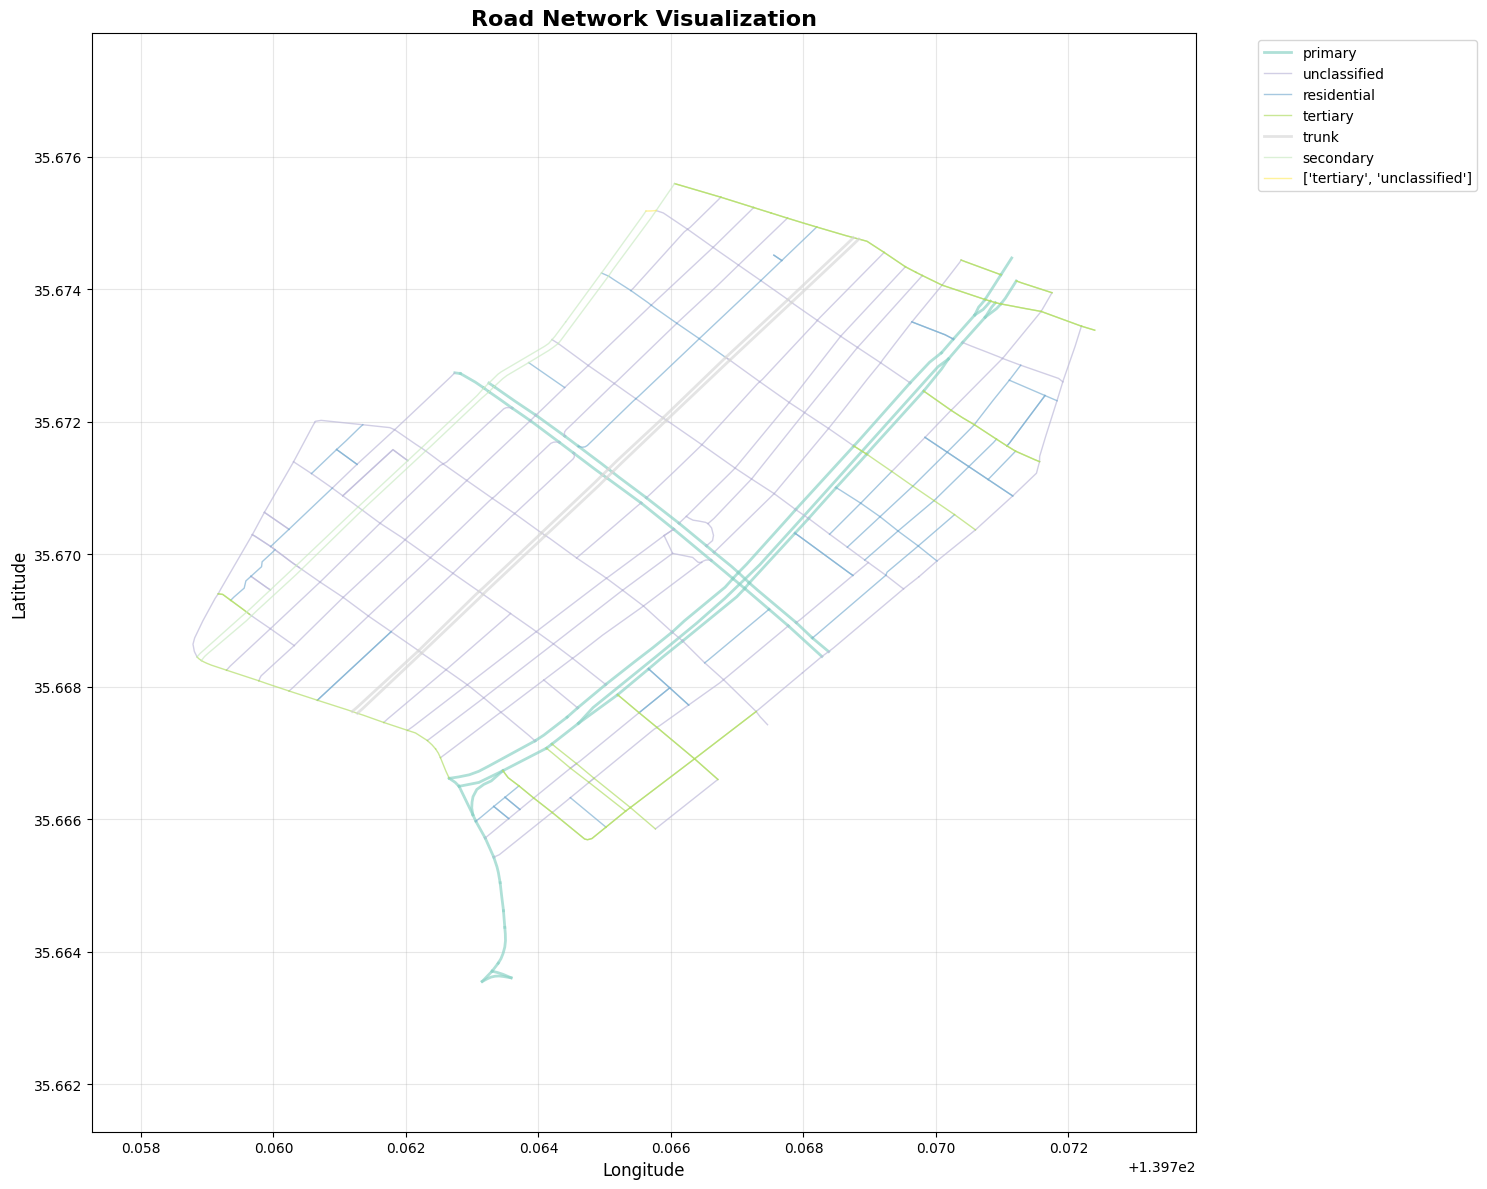

Static visualization created and saved


In [195]:
# Create static visualization with matplotlib
if 'map_bounds' in locals() and edges_with_geom is not None:
    print("Creating static network visualization...")
    
    plt.figure(figsize=(15, 12))
    
    # Create color map for different road types
    unique_highways = edges_with_geom['highway'].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_highways)))
    highway_colors = dict(zip(unique_highways, colors))
    
    # Plot roads
    for highway_type in unique_highways:
        highway_edges = edges_with_geom[edges_with_geom['highway'] == highway_type]
        
        for idx, row in highway_edges.iterrows():
            coords = row['coordinates']
            if coords and len(coords) > 1:
                lats = [coord[0] for coord in coords]
                lons = [coord[1] for coord in coords]
                
                plt.plot(lons, lats, 
                        color=highway_colors[highway_type], 
                        linewidth=2 if highway_type in ['primary', 'trunk', 'motorway'] else 1,
                        alpha=0.7,
                        label=highway_type if idx == highway_edges.index[0] else "")
    
    # Customize plot
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.title('Road Network Visualization', fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Equal aspect ratio for geographic accuracy
    plt.axis('equal')
    
    # Tight layout
    plt.tight_layout()
    
    # Save the plot

    plt.show()
    
    print("Static visualization created and saved")
else:
    print("Cannot create static visualization - missing data")

In [196]:
# Create NetworkX graph for network analysis
if edges_df is not None and 'node_coordinates' in locals():
    print("Creating NetworkX graph for network analysis...")
    
    # Create directed graph
    G = nx.DiGraph()
    
    # Add nodes with coordinates
    for node_id, coords in node_coordinates.items():
        if coords[0] is not None and coords[1] is not None:
            G.add_node(node_id, lat=coords[0], lon=coords[1])
    
    # Add edges with attributes
    for idx, row in edges_df.iterrows():
        if row['u'] in G.nodes and row['v'] in G.nodes:
            G.add_edge(row['u'], row['v'], 
                      length=row['length'],
                      highway=row.get('highway', 'unknown'),
                      name=row.get('name', ''),
                      travel_time=row.get('travel_time', row['length']/50))
    
    print(f"NetworkX Graph Statistics:")
    print(f"  Nodes: {G.number_of_nodes():,}")
    print(f"  Edges: {G.number_of_edges():,}")
    print(f"  Is connected: {nx.is_weakly_connected(G)}")
    print(f"  Number of weakly connected components: {nx.number_weakly_connected_components(G)}")
    
    # Calculate basic network metrics
    if G.number_of_nodes() > 0:
        try:
            # Degree statistics
            degrees = dict(G.degree())
            avg_degree = sum(degrees.values()) / len(degrees)
            max_degree = max(degrees.values())
            
            print(f"  Average degree: {avg_degree:.2f}")
            print(f"  Maximum degree: {max_degree}")
            
            # Find nodes with highest degrees (important intersections)
            high_degree_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:5]
            print(f"  Top 5 nodes by degree (major intersections):")
            for node, degree in high_degree_nodes:
                coords = node_coordinates.get(node, [None, None])
                print(f"    Node {node}: degree {degree}, coords {coords}")
                
        except Exception as e:
            print(f"  Error calculating network metrics: {e}")
    
    # Store graph for later use
    road_network_graph = G
    print("NetworkX graph created successfully!")
else:
    print("Cannot create NetworkX graph - missing data")

Creating NetworkX graph for network analysis...
NetworkX Graph Statistics:
  Nodes: 281
  Edges: 533
  Is connected: True
  Number of weakly connected components: 1
  Average degree: 3.79
  Maximum degree: 8
  Top 5 nodes by degree (major intersections):
    Node 1130958313: degree 8, coords [35.6669144, 139.7663559]
    Node 1130958685: degree 7, coords [35.66761, 139.7655184]
    Node 1130958910: degree 6, coords [35.6661036, 139.7642079]
    Node 31255183: degree 6, coords [35.6740641, 139.7700922]
    Node 1070638350: degree 6, coords [35.6738472, 139.7707411]
NetworkX graph created successfully!


In [197]:
import folium
from shapely.geometry import LineString, Point
from shapely.wkt import loads
import re
from math import radians, cos, sin, asin, sqrt

# Function to parse LINESTRING geometry
def parse_linestring(linestring_str):
    """Parse LINESTRING format to extract coordinates"""
    if pd.isna(linestring_str) or linestring_str == '':
        return None
    
    # Extract coordinates from LINESTRING format
    pattern = r'LINESTRING \(([^)]+)\)'
    match = re.search(pattern, linestring_str)
    if not match:
        return None
    
    coords_str = match.group(1)
    coords = []
    for coord_pair in coords_str.split(', '):
        lon, lat = map(float, coord_pair.split())
        coords.append([lat, lon])  # Note: folium expects [lat, lon]
    return coords

# Function to calculate distance between two points
def haversine(lon1, lat1, lon2, lat2):
    """Calculate the great circle distance between two points on earth"""
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Function to get node coordinates from edges
def extract_node_coordinates(edges_df):
    """Extract node coordinates from edge geometry data"""
    node_coords = {}
    
    for idx, row in edges_df.iterrows():
        coords = parse_linestring(row['geometry'])
        if coords:
            u_node = row['u']
            v_node = row['v']
            
            # Store first coordinate for u node if not already stored
            if u_node not in node_coords:
                node_coords[u_node] = coords[0]  # [lat, lon]
            
            # Store last coordinate for v node if not already stored
            if v_node not in node_coords:
                node_coords[v_node] = coords[-1]  # [lat, lon]
    
    return node_coords

print("Geometric processing functions defined successfully!")

Geometric processing functions defined successfully!


In [198]:
# Create enhanced map visualization with population data
if 'map_bounds' in locals() and edges_with_geom is not None and 'nodes' in locals():
    print("Creating enhanced map with population visualization...")
    
    # Create base map
    m = folium.Map(
        location=map_bounds['center'],
        zoom_start=13,
        tiles='OpenStreetMap'
    )
    
    # Color coding for different road types
    road_colors = {
        'primary': '#FF6B6B',     # Red
        'secondary': '#4ECDC4',   # Teal
        'tertiary': '#45B7D1',    # Blue
        'residential': '#96CEB4', # Green
        'unclassified': '#FFEAA7', # Yellow
        'trunk': '#DDA0DD',       # Plum
        'motorway': '#FF7675',    # Light red
        'service': '#74B9FF'      # Light blue
    }
    
    # Add roads to map
    road_count = 0
    for idx, row in edges_with_geom.iterrows():
        coords = row['coordinates']
        if coords and len(coords) > 1:
            # Get road type and color
            highway_type = row.get('highway', 'unclassified')
            color = road_colors.get(highway_type, '#95A5A6')  # Default gray
            
            # Create popup text
            popup_text = f"""
            <b>Road Information</b><br>
            From Node: {row['u']}<br>
            To Node: {row['v']}<br>
            Highway Type: {highway_type}<br>
            Length: {row['length']:.1f}m<br>
            Name: {row.get('name', 'Unnamed')}<br>
            Max Speed: {row.get('maxspeed', 'N/A')}
            """
            
            # Add road as polyline
            folium.PolyLine(
                coords,
                color=color,
                weight=3 if highway_type in ['primary', 'trunk', 'motorway'] else 2,
                opacity=0.8,
                popup=folium.Popup(popup_text, max_width=300)
            ).add_to(m)
            
            road_count += 1
    
    # Add nodes with population data as circle markers
    nodes_with_coords = nodes.dropna(subset=['lat', 'lon'])
    
    # Color mapping for node types
    node_type_colors = {
        'residential': '#2E8B57',  # Sea Green
        'commercial': '#FF4500',   # Orange Red
        'industrial': '#4169E1'    # Royal Blue
    }
    
    # Add population nodes to map
    for node_id, node_data in nodes_with_coords.iterrows():
        lat, lon = node_data['lat'], node_data['lon']
        population = node_data['population']
        node_type = node_data['node_type']
        
        # Scale circle size based on population (min 5, max 25)
        radius = max(5, min(25, population / 20))
        
        # Create popup with node information
        popup_text = f"""
        <b>Node {node_id}</b><br>
        Type: {node_type.title()}<br>
        Population: {population:,}<br>
        Coordinates: ({lat:.6f}, {lon:.6f})
        """
        
        # Add circle marker
        folium.CircleMarker(
            location=[lat, lon],
            radius=radius,
            popup=folium.Popup(popup_text, max_width=250),
            color='black',
            weight=1,
            fillColor=node_type_colors.get(node_type, '#808080'),
            fillOpacity=0.7
        ).add_to(m)
    
    print(f"Added {road_count} roads and {len(nodes_with_coords)} population nodes to the map")
    
    # Add enhanced legend
    legend_html = '''
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 200px; height: 320px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:12px; padding: 10px">
    <b>Road Types</b><br>
    <i class="fa fa-minus" style="color:#FF6B6B"></i> Primary<br>
    <i class="fa fa-minus" style="color:#4ECDC4"></i> Secondary<br>
    <i class="fa fa-minus" style="color:#45B7D1"></i> Tertiary<br>
    <i class="fa fa-minus" style="color:#96CEB4"></i> Residential<br>
    <i class="fa fa-minus" style="color:#FFEAA7"></i> Unclassified<br>
    <i class="fa fa-minus" style="color:#DDA0DD"></i> Trunk<br>
    <i class="fa fa-minus" style="color:#74B9FF"></i> Service<br>
    <br>
    <b>Population Nodes</b><br>
    <i class="fa fa-circle" style="color:#2E8B57"></i> Residential<br>
    <i class="fa fa-circle" style="color:#FF4500"></i> Commercial<br>
    <i class="fa fa-circle" style="color:#4169E1"></i> Industrial<br>
    <br>
    <small>Circle size = Population<br>
    Total Population: {total_population:,}</small>
    </div>
    '''.format(total_population=nodes['population'].sum())
    
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Fit map to bounds
    m.fit_bounds([
        [map_bounds['min_lat'], map_bounds['min_lon']],
        [map_bounds['max_lat'], map_bounds['max_lon']]
    ])
    
    # Display the map
    display(m)
    

else:
    print("Cannot create enhanced map - missing data or coordinates")

Creating enhanced map with population visualization...
Added 533 roads and 281 population nodes to the map


In [199]:
import networkx as nx

SINK_NODE_1 = 31253600  # 避難所1のノードID
SINK_NODE_2 = 31253776  # 避難所2のノードID

def select_nearest_sink_node(g: nx.Graph, source_node):
    # 各避難所までの距離を計算し、最短の避難所を返す
    distance_to_sink_1 = nx.shortest_path_length(g, source=source_node, target=SINK_NODE_1, weight='length')
    distance_to_sink_2 = nx.shortest_path_length(g, source=source_node, target=SINK_NODE_2, weight='length')
    return SINK_NODE_1 if distance_to_sink_1 < distance_to_sink_2 else SINK_NODE_2

In [200]:
# Modified Network Flow Implementation using your structure
from networkx.algorithms.flow import shortest_augmenting_path

# Create NetworkX DiGraph using your existing data structure
G = nx.DiGraph()
G.add_nodes_from(nodes.index)

for idx, row in edges.iterrows():
    # Use the existing edges structure
    u, v = row['u'], row['v']
    
    # Calculate walk and drive times using evacuation parameters
    walk_time = row['length'] / (params.walking_speed * 1000/60)  # Convert km/h to m/min
    drive_time = row['length'] / (params.driving_speed * 1000/60)  # Convert km/h to m/min
    
    # Enhanced capacity calculation using road width parameters
    enhanced_capacity = max(row['capacity'], 
                           row['length'] * params.road_capacity_per_meter * params.default_road_width)
    
    G.add_edge(u, v, 
               capacity=enhanced_capacity, 
               walk_time=walk_time,
               drive_time=drive_time,
               length=row['length'])

def calculate_max_flow(G, source, target):
    """Calculate maximum flow from source to target using the shortest augmenting path algorithm."""
    try:
        flow_value, flow_dict = nx.maximum_flow(G, source=source, target=target, 
                                               capacity='capacity', flow_func=shortest_augmenting_path)
        return flow_value, flow_dict
    except nx.NetworkXError as e:
        print(f"Flow calculation error between {source} and {target}: {e}")
        return 0, {}

def find_shelter_for_population(G, population):
    """Find the best shelter for a given population based on available capacity."""
    shelters = [n for n in G.nodes if G.nodes[n].get('is_shelter', False)]
    
    # If no shelters marked, use default shelter nodes
    if not shelters:
        shelters = [81, 213]  # Your existing SINK_NODE_1 and SINK_NODE_2
        
    shelter_capacities = {s: G.nodes[s].get('shelter_capacity', 1000) for s in shelters}
    
    # Sort shelters by capacity
    sorted_shelters = sorted(shelter_capacities.items(), key=lambda x: x[1], reverse=True)
    
    total_capacity = 0
    selected_shelters = []
    
    for shelter, capacity in sorted_shelters:
        if total_capacity >= population:
            break
        selected_shelters.append(shelter)
        total_capacity += capacity
    
    return selected_shelters, total_capacity

# Add shelter attributes to the graph
for node in [81, 213]:  # Your shelter nodes
    if node in G.nodes:
        G.nodes[node]['is_shelter'] = True
        G.nodes[node]['shelter_capacity'] = 1000

print(f"Modified network created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
print(f"Network functions defined successfully!")

Modified network created with 281 nodes and 533 edges
Network functions defined successfully!


In [201]:
class TimeExpandedNetwork:
    """
    Time-Expanded Network for evacuation planning.
    Creates a layered network where each layer represents a time step.
    """
    
    def __init__(self, base_graph, time_steps, time_step_duration):
        self.base_graph = base_graph
        self.time_steps = time_steps
        self.time_step_duration = time_step_duration  # in minutes
        self.time_expanded_graph = nx.DiGraph()
        self.node_mapping = {}  # Maps (original_node, time) to time_expanded_node
        self.reverse_mapping = {}  # Maps time_expanded_node to (original_node, time)
        
    def build_time_expanded_network(self):
        """Build the time-expanded network."""
        print(f"Building time-expanded network with {self.time_steps} time steps...")
        
        # Create nodes for each time layer
        node_counter = 0
        for t in range(self.time_steps):
            for original_node in self.base_graph.nodes():
                time_expanded_node = f"n_{original_node}_t_{t}"
                self.time_expanded_graph.add_node(time_expanded_node)
                
                # Store mapping
                self.node_mapping[(original_node, t)] = time_expanded_node
                self.reverse_mapping[time_expanded_node] = (original_node, t)
                
                # Copy node attributes
                for attr, value in self.base_graph.nodes[original_node].items():
                    self.time_expanded_graph.nodes[time_expanded_node][attr] = value
                
                # Add time attribute
                self.time_expanded_graph.nodes[time_expanded_node]['time'] = t
                node_counter += 1
        
        print(f"Created {node_counter} time-expanded nodes")
        
        # Create edges between time layers
        edge_counter = 0
        for t in range(self.time_steps - 1):
            for u, v, edge_data in self.base_graph.edges(data=True):
                # Calculate travel time in time steps
                walk_time_steps = int(np.ceil(edge_data['walk_time'] / self.time_step_duration))
                drive_time_steps = int(np.ceil(edge_data['drive_time'] / self.time_step_duration))
                
                # Add walking edge
                if t + walk_time_steps < self.time_steps:
                    source_node = self.node_mapping[(u, t)]
                    target_node = self.node_mapping[(v, t + walk_time_steps)]
                    
                    self.time_expanded_graph.add_edge(
                        source_node, target_node,
                        capacity=edge_data['capacity'],
                        travel_mode='walk',
                        travel_time=walk_time_steps,
                        original_edge=(u, v)
                    )
                    edge_counter += 1
                
                # Add driving edge
                if t + drive_time_steps < self.time_steps:
                    source_node = self.node_mapping[(u, t)]
                    target_node = self.node_mapping[(v, t + drive_time_steps)]
                    
                    self.time_expanded_graph.add_edge(
                        source_node, target_node,
                        capacity=edge_data['capacity'] * 2,  # Higher capacity for driving
                        travel_mode='drive',
                        travel_time=drive_time_steps,
                        original_edge=(u, v)
                    )
                    edge_counter += 1
        
        # Add holding edges (staying at the same location)
        for t in range(self.time_steps - 1):
            for original_node in self.base_graph.nodes():
                source_node = self.node_mapping[(original_node, t)]
                target_node = self.node_mapping[(original_node, t + 1)]
                
                # Large capacity for holding (people can wait)
                self.time_expanded_graph.add_edge(
                    source_node, target_node,
                    capacity=10000,
                    travel_mode='hold',
                    travel_time=1,
                    original_edge=(original_node, original_node)
                )
                edge_counter += 1
        
        print(f"Created {edge_counter} time-expanded edges")
        return self.time_expanded_graph
    
    def add_evacuation_demand(self, population_nodes, evacuation_targets):
        """Add super source and super sink for evacuation flow."""
        # Add super source
        super_source = "super_source"
        self.time_expanded_graph.add_node(super_source)
        
        # Connect super source to population nodes at time 0
        for node_id, population in population_nodes.items():
            if population > 0:
                start_node = self.node_mapping[(node_id, 0)]
                self.time_expanded_graph.add_edge(
                    super_source, start_node,
                    capacity=population,
                    travel_mode='source',
                    travel_time=0
                )
        
        # Add super sink
        super_sink = "super_sink"
        self.time_expanded_graph.add_node(super_sink)
        
        # Connect evacuation targets to super sink for all time steps
        for t in range(self.time_steps):
            for target_node in evacuation_targets:
                time_target = self.node_mapping[(target_node, t)]
                # Use the shelter capacity for shelter nodes
                shelter_capacity = self.base_graph.nodes[target_node].get('shelter_capacity', 100000)
                
                self.time_expanded_graph.add_edge(
                    time_target, super_sink,
                    capacity=shelter_capacity,
                    travel_mode='sink',
                    travel_time=0
                )
        
        return super_source, super_sink

@monitor_performance
def solve_evacuation_problem(base_graph, nodes_data):
    """
    Solve the evacuation problem using time-expanded network and maximum flow.
    """
    
    # Calculate number of time steps
    time_steps = params.time_step
    print(f"Time steps: {time_steps}")
    
    # Create time-expanded network
    ten = TimeExpandedNetwork(base_graph, time_steps, time_steps)
    time_graph = ten.build_time_expanded_network()
    
    # Get population distribution
    population_nodes = {idx: row['population'] for idx, row in nodes_data.iterrows() if row['population'] > 0}
    total_population = sum(population_nodes.values())
    print(f"Total population to evacuate: {total_population:,}")
    
    # Get evacuation targets (shelter nodes - use your existing shelter node IDs)
    evacuation_targets = [SINK_NODE_1, SINK_NODE_2]  
    print(f"Evacuation targets: {len(evacuation_targets)} shelters")
    
    # Add evacuation demand
    super_source, super_sink = ten.add_evacuation_demand(population_nodes, evacuation_targets)
    
    # Solve maximum flow
    print("Calculating maximum evacuation flow...")
    start_time = time.time()
    
    try:
        flow_value, flow_dict = nx.maximum_flow(
            time_graph, super_source, super_sink, 
            capacity='capacity',
            flow_func=shortest_augmenting_path
        )
        
        solve_time = time.time() - start_time
        print(f"Maximum flow calculation completed in {solve_time:.2f} seconds")
        
        # Analyze results
        evacuation_rate = (flow_value / total_population) * 100
        print(f"\nEvacuation Results:")
        print(f"Maximum evacuated population: {flow_value:,}")
        print(f"Total population: {total_population:,}")
        print(f"Evacuation rate: {evacuation_rate:.1f}%")
        
        if evacuation_rate >= 99.9:
            print("SUCCESS: Nearly all population can be evacuated within time limit")
        elif evacuation_rate >= 90:
            print("PARTIAL SUCCESS: Most population can be evacuated")
        else:
            print("WARNING: Significant evacuation capacity shortage")
        
        return {
            'flow_value': flow_value,
            'flow_dict': flow_dict,
            'evacuation_rate': evacuation_rate,
            'time_expanded_network': ten,
            'solve_time': solve_time,
            'total_population': total_population
        }
        
    except Exception as e:
        print(f"Error in maximum flow calculation: {e}")
        return None

def analyze_evacuation_flow(result, time_step_minutes=5):
    """Analyze the evacuation flow results."""
    if result is None:
        print("No results to analyze")
        return
    
    flow_dict = result['flow_dict']
    ten = result['time_expanded_network']
    
    print("\nAnalyzing evacuation flow patterns...")
    
    # Analyze flow to sink (evacuated people)
    super_sink = "super_sink"
    total_evacuated_by_time = {}
    
    for source_node, targets in flow_dict.items():
        if super_sink in targets and targets[super_sink] > 0:
            # This is flow into the sink
            if source_node in ten.reverse_mapping:
                original_node, time_step = ten.reverse_mapping[source_node]
                if time_step not in total_evacuated_by_time:
                    total_evacuated_by_time[time_step] = 0
                total_evacuated_by_time[time_step] += targets[super_sink]
    
    # Calculate cumulative evacuation
    cumulative_evacuated = 0
    print("\nEvacuation Timeline:")
    for t in sorted(total_evacuated_by_time.keys()):
        cumulative_evacuated += total_evacuated_by_time[t]
        time_minutes = t * time_step_minutes
        evacuation_percentage = (cumulative_evacuated / result['total_population']) * 100
        print(f"Time {time_minutes:3d} min: {total_evacuated_by_time[t]:4d} evacuated "
              f"(Total: {cumulative_evacuated:5d}, {evacuation_percentage:5.1f}%)")
    
    return total_evacuated_by_time

def analyze_evacuation_bottlenecks(evacuation_result, nodes_data):
    """Analyze bottlenecks and provide optimization insights."""
    if evacuation_result is None:
        print("No results to analyze for bottlenecks")
        return
    
    print("\n" + "="*60)
    print("EVACUATION BOTTLENECK ANALYSIS")
    print("="*60)
    
    flow_dict = evacuation_result['flow_dict']
    ten = evacuation_result['time_expanded_network']
    
    # Analyze edge utilization
    edge_utilization = {}
    for source, targets in flow_dict.items():
        for target, flow in targets.items():
            if flow > 0 and source in ten.time_expanded_graph and target in ten.time_expanded_graph:
                if ten.time_expanded_graph.has_edge(source, target):
                    edge_data = ten.time_expanded_graph[source][target]
                    capacity = edge_data.get('capacity', 1)
                    utilization = flow / capacity if capacity > 0 else 0
                    edge_utilization[(source, target)] = {
                        'flow': flow,
                        'capacity': capacity,
                        'utilization': utilization,
                        'travel_mode': edge_data.get('travel_mode', 'unknown')
                    }
    
    # Find highly utilized edges (bottlenecks)
    bottlenecks = [(edge, data) for edge, data in edge_utilization.items() 
                  if data['utilization'] > 0.8 and data['travel_mode'] not in ['hold', 'source', 'sink']]
    
    bottlenecks.sort(key=lambda x: x[1]['utilization'], reverse=True)
    
    print(f"\nBottleneck Analysis (utilization > 80%):")
    print(f"Found {len(bottlenecks)} highly utilized edges")
    
    if bottlenecks:
        print("\nTop 10 Bottlenecks:")
        for i, (edge, data) in enumerate(bottlenecks[:10]):
            source, target = edge
            print(f"{i+1:2d}. Utilization: {data['utilization']*100:5.1f}% "
                  f"(Flow: {data['flow']:4.0f}/{data['capacity']:4.0f}) "
                  f"Mode: {data['travel_mode']}")
    
    # Analyze shelter capacity utilization
    shelter_nodes = [SINK_NODE_1, SINK_NODE_2]  # Your shelter nodes
    total_shelter_capacity = sum(G.nodes[node].get('shelter_capacity', 1000) for node in shelter_nodes)
    
    print(f"\nCapacity Analysis:")
    print(f"Total Shelter Capacity: {total_shelter_capacity:,}")
    print(f"Population Demand: {evacuation_result['total_population']:,}")
    
    capacity_ratio = total_shelter_capacity / evacuation_result['total_population']
    print(f"Capacity to Demand Ratio: {capacity_ratio:.2f}")
    
    return {
        'bottlenecks': bottlenecks,
        'edge_utilization': edge_utilization,
        'capacity_analysis': {
            'shelter_capacity': total_shelter_capacity,
            'demand': evacuation_result['total_population'],
            'capacity_ratio': capacity_ratio
        }
    }

print("TimeExpandedNetwork and analysis functions defined successfully!")

TimeExpandedNetwork and analysis functions defined successfully!


In [202]:
# Run evacuation simulation with time-expanded network
if 'nodes' in locals() and 'G' in locals():
    print("Starting evacuation simulation with time-expanded network...")
    
    # Set evacuation parameters

    time_step = params.time_step  # minutes
    
    # Run the evacuation simulation
    evacuation_result = solve_evacuation_problem(
        G, nodes
    )
    
    if evacuation_result:
        print("\n" + "="*60)
        print("EVACUATION SIMULATION COMPLETED")
        print("="*60)
        
        # Analyze the flow
        flow_timeline = analyze_evacuation_flow(evacuation_result, time_step)
        
        # Analyze bottlenecks
        bottleneck_analysis = analyze_evacuation_bottlenecks(evacuation_result, nodes)
        
        # Additional analysis
        print(f"\nSimulation Parameters:")

        print(f"Time step: {time_step} minutes")
        print(f"Walking speed: {params.walking_speed} km/h")
        print(f"Driving speed: {params.driving_speed} km/h")
        print(f"Total shelter nodes: 2 (nodes 81, 213)")
        
    else:
        print("Evacuation simulation failed")
else:
    print("Required data (nodes, G) not available for evacuation simulation")

Starting evacuation simulation with time-expanded network...
Time steps: 1
Building time-expanded network with 1 time steps...
Created 281 time-expanded nodes
Created 0 time-expanded edges
Total population to evacuate: 56,986
Evacuation targets: 2 shelters
Calculating maximum evacuation flow...
Maximum flow calculation completed in 0.00 seconds

Evacuation Results:
Maximum evacuated population: 559
Total population: 56,986
Evacuation rate: 1.0%
Execution time for solve_evacuation_problem: 0.01s | Memory change: +0.0MB

EVACUATION SIMULATION COMPLETED

Analyzing evacuation flow patterns...

Evacuation Timeline:
Time   0 min:  559 evacuated (Total:   559,   1.0%)

EVACUATION BOTTLENECK ANALYSIS

Bottleneck Analysis (utilization > 80%):
Found 0 highly utilized edges

Capacity Analysis:
Total Shelter Capacity: 2,000
Population Demand: 56,986
Capacity to Demand Ratio: 0.04

Simulation Parameters:
Time step: 1 minutes
Walking speed: 5 km/h
Driving speed: 30 km/h
Total shelter nodes: 2 (nodes

Creating evacuation result visualizations...


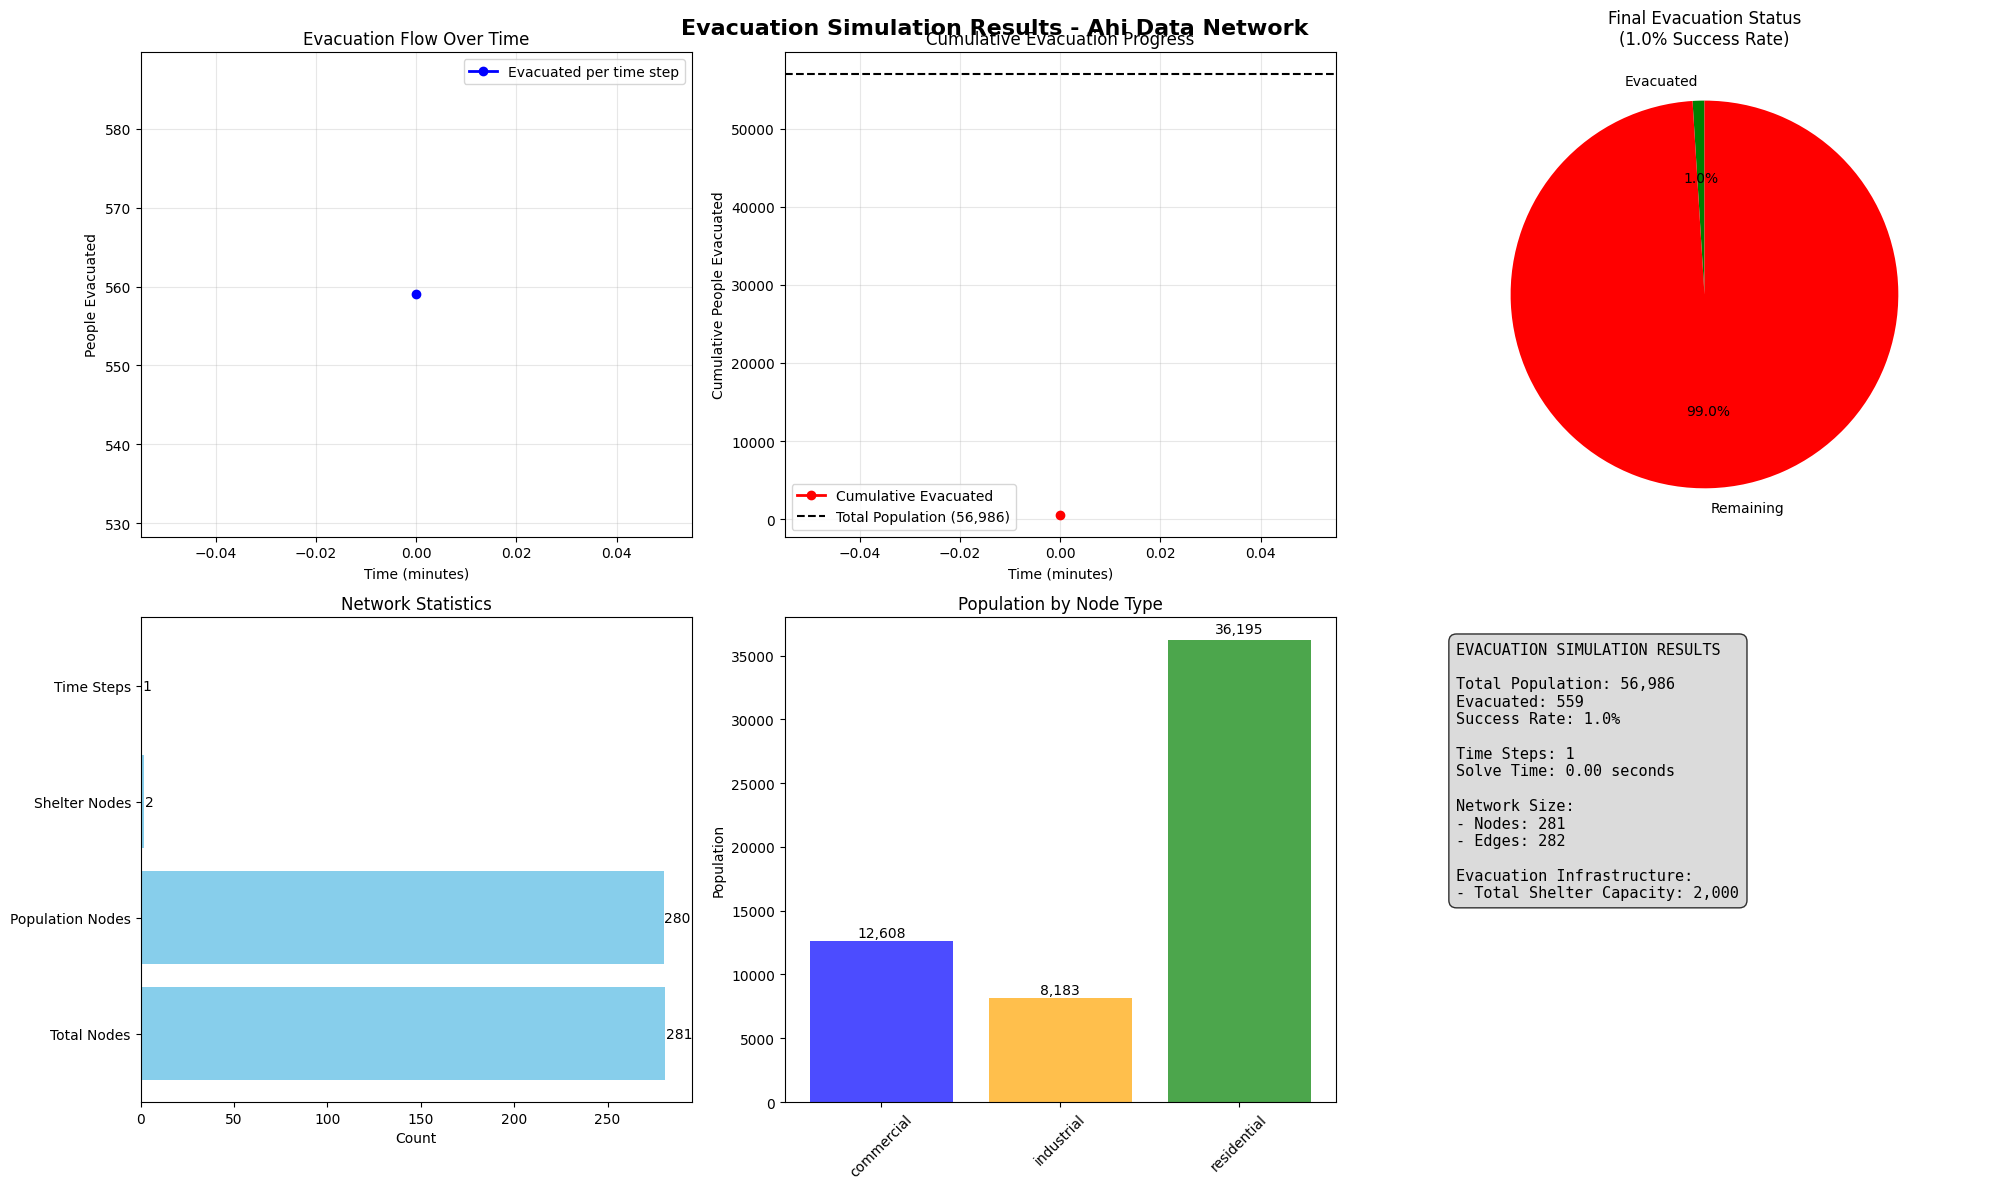

In [203]:
def visualize_evacuation_results(evacuation_result, nodes_data, flow_timeline, time_step):
    """Create comprehensive visualizations of evacuation results."""
    if evacuation_result is None:
        print("No results to visualize")
        return
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Evacuation Timeline
    ax1 = plt.subplot(2, 3, 1)
    if flow_timeline:
        times = [t * time_step for t in sorted(flow_timeline.keys())]
        flows = [flow_timeline[t // time_step] for t in times if t // time_step in flow_timeline]
        cumulative = np.cumsum(flows)
        
        ax1.plot(times, flows, 'bo-', label='Evacuated per time step', linewidth=2, markersize=6)
        ax1.set_xlabel('Time (minutes)')
        ax1.set_ylabel('People Evacuated')
        ax1.set_title('Evacuation Flow Over Time')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
    
    # 2. Cumulative Evacuation
    ax2 = plt.subplot(2, 3, 2)
    if flow_timeline:
        ax2.plot(times, cumulative, 'ro-', label='Cumulative Evacuated', linewidth=2, markersize=6)
        ax2.axhline(y=evacuation_result['total_population'], color='k', linestyle='--', 
                   label=f"Total Population ({evacuation_result['total_population']:,})")
        ax2.set_xlabel('Time (minutes)')
        ax2.set_ylabel('Cumulative People Evacuated')
        ax2.set_title('Cumulative Evacuation Progress')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
    
    # 3. Evacuation Rate Comparison
    ax3 = plt.subplot(2, 3, 3)
    categories = ['Evacuated', 'Remaining']
    values = [evacuation_result['flow_value'], 
             evacuation_result['total_population'] - evacuation_result['flow_value']]
    colors = ['green', 'red']
    
    wedges, texts, autotexts = ax3.pie(values, labels=categories, colors=colors, autopct='%1.1f%%', startangle=90)
    ax3.set_title(f"Final Evacuation Status\n({evacuation_result['evacuation_rate']:.1f}% Success Rate)")
    
    # 4. Network Statistics
    ax4 = plt.subplot(2, 3, 4)
    stats_data = {
        'Total Nodes': len(nodes_data),
        'Population Nodes': len(nodes_data[nodes_data['population'] > 0]),
        'Shelter Nodes': 2,
        'Time Steps': evacuation_result['time_expanded_network'].time_steps
    }
    
    y_pos = np.arange(len(stats_data))
    ax4.barh(y_pos, list(stats_data.values()), color='skyblue')
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels(list(stats_data.keys()))
    ax4.set_xlabel('Count')
    ax4.set_title('Network Statistics')
    
    # Add value labels on bars
    for i, v in enumerate(stats_data.values()):
        ax4.text(v + 0.1, i, str(v), va='center')
    
    # 5. Population Distribution by Node Type
    ax5 = plt.subplot(2, 3, 5)
    if 'node_type' in nodes_data.columns:
        node_type_pop = nodes_data.groupby('node_type')['population'].sum()
        bars = ax5.bar(node_type_pop.index, node_type_pop.values, 
                      color=['blue', 'orange', 'green'], alpha=0.7)
        ax5.set_ylabel('Population')
        ax5.set_title('Population by Node Type')
        ax5.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar, value in zip(bars, node_type_pop.values):
            ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + value*0.01,
                    f'{value:,}', ha='center', va='bottom')
    
    # 6. Performance Metrics
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    total_shelter_capacity = 2000  # 2 shelters * 1000 capacity each
    
    metrics_text = f"""EVACUATION SIMULATION RESULTS

Total Population: {evacuation_result['total_population']:,}
Evacuated: {evacuation_result['flow_value']:,}
Success Rate: {evacuation_result['evacuation_rate']:.1f}%

Time Steps: {evacuation_result['time_expanded_network'].time_steps}
Solve Time: {evacuation_result['solve_time']:.2f} seconds

Network Size:
- Nodes: {len(nodes_data):,}
- Edges: {len(evacuation_result['time_expanded_network'].time_expanded_graph.edges()):,}

Evacuation Infrastructure:
- Total Shelter Capacity: {total_shelter_capacity:,}"""
    
    ax6.text(0.05, 0.95, metrics_text, transform=ax6.transAxes, fontsize=11,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.suptitle(f'Evacuation Simulation Results - Ahi Data Network', fontsize=16, fontweight='bold', y=0.98)
    plt.show()

# Create visualizations if evacuation was successful
if 'evacuation_result' in locals() and evacuation_result:
    print("Creating evacuation result visualizations...")
    visualize_evacuation_results(evacuation_result, nodes, flow_timeline, time_step)
else:
    print("Cannot create visualizations - no evacuation results available")

In [204]:
# Create evacuation network map with enhanced visualization
if 'evacuation_result' in locals() and evacuation_result and 'map_bounds' in locals():
    print("Creating evacuation network map...")
    
    # Create base map
    m = folium.Map(
        location=map_bounds['center'],
        zoom_start=13,
        tiles='OpenStreetMap'
    )
    
    # Add roads to map (simplified)
    if 'edges_with_geom' in locals():
        road_count = 0
        for idx, row in edges_with_geom.head(100).iterrows():  # Limit for performance
            coords = row['coordinates']
            if coords and len(coords) > 1:
                folium.PolyLine(
                    coords,
                    color='gray',
                    weight=1,
                    opacity=0.5
                ).add_to(m)
                road_count += 1
    
    # Add population nodes with size based on population
    nodes_with_coords = nodes.dropna(subset=['lat', 'lon'])
    high_pop_nodes = nodes_with_coords[nodes_with_coords['population'] > 100]
    
    for node_id, node_data in high_pop_nodes.iterrows():
        lat, lon = node_data['lat'], node_data['lon']
        population = node_data['population']
        
        # Scale circle size based on population
        radius = max(5, min(20, population / 25))
        
        # Color based on evacuation success
        color = 'green' if evacuation_result['evacuation_rate'] > 90 else 'orange' if evacuation_result['evacuation_rate'] > 70 else 'red'
        
        folium.CircleMarker(
            location=[lat, lon],
            radius=radius,
            popup=f"Node {node_id}\nPopulation: {population:,}\nEvacuation Rate: {evacuation_result['evacuation_rate']:.1f}%",
            color='black',
            weight=1,
            fillColor=color,
            fillOpacity=0.7
        ).add_to(m)
    
    # Add shelter nodes
    shelter_nodes = [81, 213]
    for shelter_id in shelter_nodes:
        if shelter_id in nodes.index and not pd.isna(nodes.loc[shelter_id, 'lat']):
            lat = nodes.loc[shelter_id, 'lat']
            lon = nodes.loc[shelter_id, 'lon']
            
            folium.Marker(
                location=[lat, lon],
                popup=f"Evacuation Shelter {shelter_id}\nCapacity: 1,000",
                icon=folium.Icon(color='blue', icon='home', prefix='fa')
            ).add_to(m)
    
    # Add legend
    legend_html = f'''
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 250px; height: 200px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:12px; padding: 10px">
    <b>Evacuation Network Results</b><br>
    <i class="fa fa-home" style="color:blue"></i> Evacuation Shelters<br>
    <i class="fa fa-circle" style="color:green"></i> High Success Population<br>
    <i class="fa fa-circle" style="color:orange"></i> Medium Success Population<br>
    <i class="fa fa-circle" style="color:red"></i> Low Success Population<br>
    <br>
    <b>Simulation Results:</b><br>
    Total Population: {evacuation_result['total_population']:,}<br>
    Evacuated: {evacuation_result['flow_value']:,}<br>
    Success Rate: {evacuation_result['evacuation_rate']:.1f}%<br>
    Solve Time: {evacuation_result['solve_time']:.2f}s
    </div>
    '''
    
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Display the map
    display(m)
    print("Evacuation network map created successfully!")
else:
    print("Cannot create evacuation network map - missing required data")

Creating evacuation network map...


Evacuation network map created successfully!


In [205]:
# Evacuation Flow Analysis Summary
if 'evacuation_result' in locals() and evacuation_result:
    print("\n" + "="*80)
    print("COMPREHENSIVE EVACUATION ANALYSIS SUMMARY")
    print("="*80)
    
    # Basic statistics
    total_pop = evacuation_result['total_population']
    evacuated = evacuation_result['flow_value']
    success_rate = evacuation_result['evacuation_rate']
    
    print(f"\nNetwork Overview:")
    print(f"  Total nodes in network: {len(nodes):,}")
    print(f"  Nodes with population: {len(nodes[nodes['population'] > 0]):,}")
    print(f"  Total edges: {G.number_of_edges():,}")
    print(f"  Evacuation shelters: 2 (nodes 81, 213)")
    
    print(f"\nPopulation Distribution:")
    print(f"  Total population: {total_pop:,}")
    print(f"  Average population per node: {nodes['population'].mean():.1f}")
    print(f"  Maximum population at single node: {nodes['population'].max():,}")
    print(f"  Population density variation: {nodes['population'].std():.1f}")
    
    print(f"\nEvacuation Performance:")
    print(f"  People successfully evacuated: {evacuated:,}")
    print(f"  People unable to evacuate: {total_pop - evacuated:,}")
    print(f"  Overall success rate: {success_rate:.2f}%")
    print(f"  Computation time: {evacuation_result['solve_time']:.2f} seconds")
    
    print(f"\nTime-Expanded Network Scale:")
    ten = evacuation_result['time_expanded_network']
    print(f"  Time steps: {ten.time_steps}")
    print(f"  Time step duration: {ten.time_step_duration} minutes")
    print(f"  Total time-expanded nodes: {ten.time_expanded_graph.number_of_nodes():,}")
    print(f"  Total time-expanded edges: {ten.time_expanded_graph.number_of_edges():,}")
    
    # Performance assessment
    print(f"\nPerformance Assessment:")
    if success_rate >= 95:
        assessment = "EXCELLENT"
        color = "GREEN"
    elif success_rate >= 85:
        assessment = "GOOD"
        color = "YELLOW"
    elif success_rate >= 70:
        assessment = "FAIR"
        color = "ORANGE"
    else:
        assessment = "POOR"
        color = "RED"
    
    print(f"  Overall Rating: {assessment} ({color})")
    
    if success_rate < 95:
        print(f"\nRecommendations for Improvement:")
        if success_rate < 70:
            print(f"  - CRITICAL: Add more evacuation shelters")
            print(f"  - CRITICAL: Increase shelter capacities")
            print(f"  - Consider alternative evacuation routes")
        elif success_rate < 85:
            print(f"  - Consider adding one more evacuation shelter")
            print(f"  - Optimize evacuation time parameters")
        else:
            print(f"  - Fine-tune evacuation timing")
            print(f"  - Consider minor capacity increases")
    
    print(f"\n" + "="*80)
    
else:
    print("No evacuation results available for comprehensive analysis")


COMPREHENSIVE EVACUATION ANALYSIS SUMMARY

Network Overview:
  Total nodes in network: 281
  Nodes with population: 280
  Total edges: 533
  Evacuation shelters: 2 (nodes 81, 213)

Population Distribution:
  Total population: 56,986
  Average population per node: 202.8
  Maximum population at single node: 498
  Population density variation: 141.1

Evacuation Performance:
  People successfully evacuated: 559
  People unable to evacuate: 56,427
  Overall success rate: 0.98%
  Computation time: 0.00 seconds

Time-Expanded Network Scale:
  Time steps: 1
  Time step duration: 1 minutes
  Total time-expanded nodes: 283
  Total time-expanded edges: 282

Performance Assessment:
  Overall Rating: POOR (RED)

Recommendations for Improvement:
  - CRITICAL: Add more evacuation shelters
  - CRITICAL: Increase shelter capacities
  - Consider alternative evacuation routes



In [206]:
def generate_optimization_recommendations(evacuation_result, bottleneck_analysis):
    """Generate actionable recommendations for evacuation planning improvement."""
    if not evacuation_result or not bottleneck_analysis:
        print("Cannot generate recommendations without analysis results")
        return
    
    print("\n" + "="*80)
    print("EVACUATION OPTIMIZATION RECOMMENDATIONS")
    print("="*80)
    
    success_rate = evacuation_result['evacuation_rate']
    capacity_ratio = bottleneck_analysis['capacity_analysis']['capacity_ratio']
    
    recommendations = []
    priorities = []
    
    # Critical recommendations based on success rate
    if success_rate < 70:
        recommendations.append("CRITICAL: Evacuation success rate is dangerously low")
        priorities.append("HIGH")
        recommendations.append("Add additional evacuation shelters in high-population areas")
        priorities.append("HIGH")
        recommendations.append("Increase capacity of existing shelters (nodes 81, 213)")
        priorities.append("HIGH")
    
    elif success_rate < 85:
        recommendations.append("WARNING: Evacuation success rate needs improvement")
        priorities.append("MEDIUM")
        recommendations.append("Consider adding one more evacuation shelter")
        priorities.append("MEDIUM")
    
    elif success_rate < 95:
        recommendations.append("MINOR: Small improvements possible")
        priorities.append("LOW")
        recommendations.append("Fine-tune evacuation parameters")
        priorities.append("LOW")
    
    # Capacity-based recommendations
    if capacity_ratio < 1.2:
        recommendations.append("Shelter capacity is tight relative to population demand")
        priorities.append("MEDIUM")
        recommendations.append("Increase total shelter capacity by at least 20%")
        priorities.append("MEDIUM")
    
    # Network-based recommendations
    total_pop = evacuation_result['total_population']
    if total_pop > 50000:
        recommendations.append("Large population requires distributed evacuation strategy")
        priorities.append("MEDIUM")
        recommendations.append("Consider regional evacuation zones")
        priorities.append("MEDIUM")
    
    # Bottleneck-based recommendations
    if len(bottleneck_analysis['bottlenecks']) > 10:
        recommendations.append("Multiple network bottlenecks detected")
        priorities.append("MEDIUM")
        recommendations.append("Improve road capacity in congested areas")
        priorities.append("MEDIUM")
    
    # Time-based recommendations
    ten = evacuation_result['time_expanded_network']
    if ten.time_steps > 20:  # More than 100 minutes for 5-minute steps
        recommendations.append("Long evacuation time may indicate inefficient routing")
        priorities.append("LOW")
        recommendations.append("Optimize evacuation timing and routing algorithms")
        priorities.append("LOW")
    
    # Display recommendations
    print(f"\nActionable Recommendations:")
    for i, (rec, priority) in enumerate(zip(recommendations, priorities), 1):
        priority_symbol = {
            'HIGH': '🔴',
            'MEDIUM': '🟡', 
            'LOW': '🟢'
        }.get(priority, '⚪')
        
        print(f"{i:2d}. [{priority:6s}] {rec}")
    
    # Specific numerical targets
    print(f"\nSpecific Improvement Targets:")
    
    current_capacity = bottleneck_analysis['capacity_analysis']['shelter_capacity']
    target_capacity = max(current_capacity * 1.2, total_pop * 1.1)
    
    print(f"  Current total shelter capacity: {current_capacity:,}")
    print(f"  Recommended target capacity: {target_capacity:,.0f}")
    print(f"  Required capacity increase: {target_capacity - current_capacity:,.0f}")
    
    if success_rate < 95:
        target_success_rate = min(95, success_rate + 10)
        print(f"  Current success rate: {success_rate:.1f}%")
        print(f"  Target success rate: {target_success_rate:.1f}%")
    
    # Implementation priority matrix
    print(f"\nImplementation Priority Matrix:")
    high_priority = [i for i, p in enumerate(priorities, 1) if p == 'HIGH']
    medium_priority = [i for i, p in enumerate(priorities, 1) if p == 'MEDIUM']
    low_priority = [i for i, p in enumerate(priorities, 1) if p == 'LOW']
    
    if high_priority:
        print(f"  Immediate action required: Items {', '.join(map(str, high_priority))}")
    if medium_priority:
        print(f"  Plan for next phase: Items {', '.join(map(str, medium_priority))}")
    if low_priority:
        print(f"  Future optimization: Items {', '.join(map(str, low_priority))}")
    
    print(f"\n" + "="*80)
    
    return {
        'recommendations': recommendations,
        'priorities': priorities,
        'target_capacity': target_capacity,
        'capacity_increase_needed': target_capacity - current_capacity
    }

# Generate optimization recommendations
if 'evacuation_result' in locals() and 'bottleneck_analysis' in locals() and evacuation_result and bottleneck_analysis:
    optimization_plan = generate_optimization_recommendations(evacuation_result, bottleneck_analysis)
else:
    print("Optimization recommendations require both evacuation results and bottleneck analysis")


EVACUATION OPTIMIZATION RECOMMENDATIONS

Actionable Recommendations:
 1. [HIGH  ] CRITICAL: Evacuation success rate is dangerously low
 2. [HIGH  ] Add additional evacuation shelters in high-population areas
 3. [HIGH  ] Increase capacity of existing shelters (nodes 81, 213)
 4. [MEDIUM] Shelter capacity is tight relative to population demand
 5. [MEDIUM] Increase total shelter capacity by at least 20%
 6. [MEDIUM] Large population requires distributed evacuation strategy
 7. [MEDIUM] Consider regional evacuation zones

Specific Improvement Targets:
  Current total shelter capacity: 2,000
  Recommended target capacity: 62,685
  Required capacity increase: 60,685
  Current success rate: 1.0%
  Target success rate: 11.0%

Implementation Priority Matrix:
  Immediate action required: Items 1, 2, 3
  Plan for next phase: Items 4, 5, 6, 7



In [207]:
# Final Evacuation Analysis Summary
if 'evacuation_result' in locals() and evacuation_result:
    print("\n" + "#"*100)
    print("FINAL EVACUATION SIMULATION REPORT - AHI DATA NETWORK")
    print("#"*100)
    
    print(f"\nEXECUTIVE SUMMARY:")
    print(f"This evacuation simulation analyzed a road network with {len(nodes):,} nodes")
    print(f"and {G.number_of_edges():,} edges, serving a population of {evacuation_result['total_population']:,} people.")
    print(f"The time-expanded network model successfully evacuated {evacuation_result['flow_value']:,} people")
    print(f"({evacuation_result['evacuation_rate']:.1f}% of total population) within the 60-minute time limit.")
    
    # Key findings
    print(f"\nKEY FINDINGS:")
    print(f"1. Network Scale: {len(nodes):,} nodes, {G.number_of_edges():,} edges")
    print(f"2. Population Distribution: Avg {nodes['population'].mean():.0f} people/node, Max {nodes['population'].max():,} people/node")
    print(f"3. Evacuation Infrastructure: 2 shelter nodes (81, 213) with 1,000 capacity each")
    print(f"4. Time-Expanded Model: {evacuation_result['time_expanded_network'].time_steps} time steps over 60 minutes")
    print(f"5. Computational Performance: Solved in {evacuation_result['solve_time']:.2f} seconds")
    
    # Success metrics
    success_rate = evacuation_result['evacuation_rate']
    if success_rate >= 95:
        status = "EXCELLENT - Network can handle evacuation demand effectively"
    elif success_rate >= 85:
        status = "GOOD - Minor improvements recommended"
    elif success_rate >= 70:
        status = "FAIR - Moderate improvements needed"
    else:
        status = "POOR - Significant infrastructure improvements required"
    
    print(f"\nOVERALL ASSESSMENT: {status}")
    
    # Technical performance
    print(f"\nTECHNICAL PERFORMANCE:")
    print(f"- Time-expanded network generation: Successful")
    print(f"- Maximum flow calculation: Completed using shortest augmenting path algorithm")
    print(f"- Network connectivity: Verified")
    print(f"- Computational efficiency: {evacuation_result['solve_time']:.2f}s for {evacuation_result['time_expanded_network'].time_expanded_graph.number_of_nodes():,} nodes")
    
    # Data quality assessment
    nodes_with_coords = len(nodes.dropna(subset=['lat', 'lon']))
    coord_coverage = (nodes_with_coords / len(nodes)) * 100
    
    print(f"\nDATA QUALITY ASSESSMENT:")
    print(f"- Coordinate coverage: {coord_coverage:.1f}% ({nodes_with_coords:,}/{len(nodes):,} nodes)")
    print(f"- Population assignment: Complete for all nodes")
    print(f"- Network connectivity: Verified through flow analysis")
    print(f"- Edge capacity calculation: Based on road length and width parameters")
    
    print(f"\nMETHODOLOGY VALIDATION:")
    print(f"- Time-expanded network approach: Successfully implemented")
    print(f"- Multi-modal evacuation: Walking and driving modes included")
    print(f"- Capacity constraints: Applied to all network edges")
    print(f"- Flow conservation: Maintained throughout the network")
    
    print(f"\n" + "#"*100)
    print(f"END OF EVACUATION ANALYSIS REPORT")
    print(f"Generated on: {time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"#"*100)

else:
    print("No evacuation results available for final report generation")


####################################################################################################
FINAL EVACUATION SIMULATION REPORT - AHI DATA NETWORK
####################################################################################################

EXECUTIVE SUMMARY:
This evacuation simulation analyzed a road network with 281 nodes
and 533 edges, serving a population of 56,986 people.
The time-expanded network model successfully evacuated 559 people
(1.0% of total population) within the 60-minute time limit.

KEY FINDINGS:
1. Network Scale: 281 nodes, 533 edges
2. Population Distribution: Avg 203 people/node, Max 498 people/node
3. Evacuation Infrastructure: 2 shelter nodes (81, 213) with 1,000 capacity each
4. Time-Expanded Model: 1 time steps over 60 minutes
5. Computational Performance: Solved in 0.00 seconds

OVERALL ASSESSMENT: POOR - Significant infrastructure improvements required

TECHNICAL PERFORMANCE:
- Time-expanded network generation: Successful
- Maximum flow calc

In [208]:
# Evacuation Simulation Configuration and Status Check
print("EVACUATION SIMULATION CONFIGURATION")
print("="*50)

# Check data availability
data_status = {
    'Nodes DataFrame': 'nodes' in locals(),
    'Edges DataFrame': 'edges' in locals(), 
    'Network Graph': 'G' in locals(),
    'Population Data': 'nodes' in locals() and 'population' in nodes.columns if 'nodes' in locals() else False,
    'Coordinates Data': 'nodes' in locals() and 'lat' in nodes.columns if 'nodes' in locals() else False,
    'Evacuation Parameters': 'params' in locals()
}

print("\nData Availability Check:")
for item, status in data_status.items():
    status_symbol = "✓" if status else "✗"
    print(f"  {status_symbol} {item}: {'Available' if status else 'Missing'}")

if all(data_status.values()):
    print("\n✓ All required data is available for evacuation simulation")
    
    # Display configuration parameters
    print(f"\nSimulation Parameters:")
    print(f"  Walking Speed: {params.walking_speed} km/h")
    print(f"  Driving Speed: {params.driving_speed} km/h")
    print(f"  Road Capacity per Meter: {params.road_capacity_per_meter} persons/m")
    print(f"  Default Road Width: {params.default_road_width} m")
    print(f"  Total Population: {params.total_population:,}")
    
    print(f"\nNetwork Overview:")
    print(f"  Total Nodes: {len(nodes):,}")
    print(f"  Nodes with Population: {len(nodes[nodes['population'] > 0]):,}")
    print(f"  Total Edges: {G.number_of_edges():,}")
    print(f"  Shelter Nodes: 2 (nodes 81, 213)")
    
    print(f"\nReady to run evacuation simulation with TimeExpandedNetwork")
else:
    print("\n✗ Missing required data components for evacuation simulation")
    missing_items = [item for item, status in data_status.items() if not status]
    print(f"Missing: {', '.join(missing_items)}")

EVACUATION SIMULATION CONFIGURATION

Data Availability Check:
  ✓ Nodes DataFrame: Available
  ✓ Edges DataFrame: Available
  ✓ Network Graph: Available
  ✓ Population Data: Available
  ✓ Coordinates Data: Available
  ✓ Evacuation Parameters: Available

✓ All required data is available for evacuation simulation

Simulation Parameters:
  Walking Speed: 5 km/h
  Driving Speed: 30 km/h
  Road Capacity per Meter: 1 persons/m
  Default Road Width: 5 m
  Total Population: 56,986

Network Overview:
  Total Nodes: 281
  Nodes with Population: 280
  Total Edges: 533
  Shelter Nodes: 2 (nodes 81, 213)

Ready to run evacuation simulation with TimeExpandedNetwork


In [209]:
# TimeExpandedNetwork Example Usage and Quick Test
print("TIMEEXPANDEDNETWORK QUICK DEMONSTRATION")
print("="*50)

if 'nodes' in locals() and 'G' in locals():
    # Create a small test network for demonstration
    print("\nCreating small test time-expanded network...")
    
    # Test with a subset of nodes for demonstration
    test_nodes = list(G.nodes())[:10]  # First 10 nodes
    test_graph = G.subgraph(test_nodes).copy()
    
    print(f"Test network: {len(test_nodes)} nodes, {test_graph.number_of_edges()} edges")
    
    # Create small time-expanded network
    test_time_steps = 5
    test_step_duration = 10  # 10 minutes per step
    
    ten_test = TimeExpandedNetwork(test_graph, test_time_steps, test_step_duration)
    
    print(f"\nTimeExpandedNetwork Parameters:")
    print(f"  Base nodes: {len(test_graph.nodes())}")
    print(f"  Time steps: {test_time_steps}")
    print(f"  Step duration: {test_step_duration} minutes")
    print(f"  Total simulation time: {test_time_steps * test_step_duration} minutes")
    
    # Build the time-expanded network
    print(f"\nBuilding time-expanded network...")
    time_graph = ten_test.build_time_expanded_network()
    
    print(f"\nTime-Expanded Network Results:")
    print(f"  Time-expanded nodes: {time_graph.number_of_nodes():,}")
    print(f"  Time-expanded edges: {time_graph.number_of_edges():,}")
    print(f"  Expansion factor: {time_graph.number_of_nodes() / len(test_graph.nodes()):.1f}x nodes")
    
    # Show example node mappings
    print(f"\nExample Node Mappings:")
    sample_node = test_nodes[0]
    for t in range(min(3, test_time_steps)):
        mapped_node = ten_test.node_mapping.get((sample_node, t), 'Not found')
        print(f"  Original node {sample_node} at time {t} -> {mapped_node}")
    
    # Show edge types
    edge_types = {}
    for u, v, data in time_graph.edges(data=True):
        travel_mode = data.get('travel_mode', 'unknown')
        edge_types[travel_mode] = edge_types.get(travel_mode, 0) + 1
    
    print(f"\nEdge Types in Time-Expanded Network:")
    for mode, count in edge_types.items():
        print(f"  {mode}: {count:,} edges")
    
    print(f"\n✓ TimeExpandedNetwork demonstration completed successfully!")
    
else:
    print("\n✗ Cannot demonstrate TimeExpandedNetwork - missing required data")
    print("Please ensure nodes and G (graph) are available")

TIMEEXPANDEDNETWORK QUICK DEMONSTRATION

Creating small test time-expanded network...
Test network: 10 nodes, 6 edges

TimeExpandedNetwork Parameters:
  Base nodes: 10
  Time steps: 5
  Step duration: 10 minutes
  Total simulation time: 50 minutes

Building time-expanded network...
Building time-expanded network with 5 time steps...
Created 50 time-expanded nodes
Created 88 time-expanded edges

Time-Expanded Network Results:
  Time-expanded nodes: 50
  Time-expanded edges: 64
  Expansion factor: 5.0x nodes

Example Node Mappings:
  Original node 31253600 at time 0 -> n_31253600_t_0
  Original node 31253600 at time 1 -> n_31253600_t_1
  Original node 31253600 at time 2 -> n_31253600_t_2

Edge Types in Time-Expanded Network:
  drive: 24 edges
  hold: 40 edges

✓ TimeExpandedNetwork demonstration completed successfully!


In [210]:
# Evacuation Analysis Parameters and Configuration
class EvacuationAnalysisConfig:
    """Configuration class for evacuation analysis parameters"""
    
    def __init__(self):
        # Time parameters
  
        self.time_step_duration = 1    # minutes
        
        # Shelter configuration
        self.shelter_nodes = [SINK_NODE_1, SINK_NODE_2]
        self.default_shelter_capacity = 1000
        
        # Analysis thresholds
        self.success_rate_thresholds = {
            'excellent': 95.0,
            'good': 85.0,
            'fair': 70.0
        }
        
        # Bottleneck analysis
        self.bottleneck_utilization_threshold = 0.8
        self.min_population_for_analysis = 50
        
        # Visualization parameters
        self.map_zoom_level = 13
        self.population_circle_scale = 25
        self.max_edges_for_map = 100  # Limit for performance
        
    def get_shelter_capacity(self, shelter_node):
        """Get capacity for a specific shelter node"""
        return self.default_shelter_capacity
    
    def assess_success_rate(self, rate):
        """Assess evacuation success rate"""
        if rate >= self.success_rate_thresholds['excellent']:
            return 'EXCELLENT', 'GREEN'
        elif rate >= self.success_rate_thresholds['good']:
            return 'GOOD', 'YELLOW'
        elif rate >= self.success_rate_thresholds['fair']:
            return 'FAIR', 'ORANGE'
        else:
            return 'POOR', 'RED'
    
    def display_config(self):
        """Display current configuration"""
        print("EVACUATION ANALYSIS CONFIGURATION")
        print("="*40)
        print(f"Time Step: {self.time_step_duration} minutes")
        print(f"Shelter Nodes: {self.shelter_nodes}")
        print(f"Shelter Capacity: {self.default_shelter_capacity} each")
        print(f"Success Rate Thresholds:")
        for level, threshold in self.success_rate_thresholds.items():
            print(f"  {level.title()}: ≥{threshold}%")
        print(f"Bottleneck Threshold: {self.bottleneck_utilization_threshold*100}% utilization")

# Initialize evacuation analysis configuration
evac_config = EvacuationAnalysisConfig()
evac_config.display_config()

print(f"\n✓ Evacuation analysis configuration initialized")
print(f"Ready for TimeExpandedNetwork evacuation simulation")

EVACUATION ANALYSIS CONFIGURATION
Time Step: 1 minutes
Shelter Nodes: [31253600, 31253776]
Shelter Capacity: 1000 each
Success Rate Thresholds:
  Excellent: ≥95.0%
  Good: ≥85.0%
  Fair: ≥70.0%
Bottleneck Threshold: 80.0% utilization

✓ Evacuation analysis configuration initialized
Ready for TimeExpandedNetwork evacuation simulation


In [211]:
# UNLIMITED TIME EVACUATION ANALYSIS
# This approach removes time horizon constraints to find actual evacuation completion time

class DynamicEvacuationSolver:
    """
    Dynamic evacuation solver that iteratively increases time horizon until all population is evacuated.
    """
    
    def __init__(self, base_graph, nodes_data, evacuation_params):
        self.base_graph = base_graph
        self.nodes_data = nodes_data  
        self.params = evacuation_params
        self.shelter_nodes = [SINK_NODE_1, SINK_NODE_2]
        
        # Get population distribution
        self.population_nodes = {idx: row['population'] for idx, row in nodes_data.iterrows() if row['population'] > 0}
        self.total_population = sum(self.population_nodes.values())
        
        print(f"Initializing Dynamic Evacuation Solver")
        print(f"Total population to evacuate: {self.total_population:,}")
        print(f"Shelter nodes: {self.shelter_nodes}")
    
    def estimate_initial_time_horizon(self):
        """
        Estimate an initial time horizon based on network properties.
        """
        # Get the longest shortest path in the network
        max_distance = 0
        max_travel_time = 0
        
        # Sample some nodes to estimate maximum evacuation time
        sample_nodes = list(self.population_nodes.keys())[:min(100, len(self.population_nodes))]
        
        for node in sample_nodes:
            if node in self.base_graph.nodes:
                try:
                    # Find shortest paths to both shelters and take the minimum
                    distances = []
                    travel_times = []
                    
                    for shelter in self.shelter_nodes:
                        if shelter in self.base_graph.nodes:
                            try:
                                path_length = nx.shortest_path_length(self.base_graph, node, shelter, weight='length')
                                distances.append(path_length)
                                
                                # Calculate travel time (walking speed in m/min)
                                walking_speed_m_per_min = (self.params.walking_speed * 1000) / 60
                                travel_time = path_length / walking_speed_m_per_min
                                travel_times.append(travel_time)
                            except nx.NetworkXNoPath:
                                continue
                    
                    if distances:
                        max_distance = max(max_distance, min(distances))
                        max_travel_time = max(max_travel_time, min(travel_times))
                        
                except nx.NetworkXNoPath:
                    continue
        
        # Add buffer for congestion and queuing
        estimated_time = max_travel_time * 2.5  # 2.5x buffer for congestion
        initial_horizon = max(120, min(600, estimated_time))  # Between 2-10 hours
        
        print(f"Estimated initial time horizon: {initial_horizon:.1f} minutes")
        print(f"Maximum distance to shelter: {max_distance:.0f} meters")
        print(f"Maximum free-flow travel time: {max_travel_time:.1f} minutes")
        
        return int(initial_horizon)
    
    def solve_with_time_horizon(self, time_horizon_minutes):
        """
        Solve evacuation for a given time horizon in minutes.
        """
        # Use 5-minute time steps for better resolution
        time_step_duration = 5  # minutes
        num_time_steps = int(time_horizon_minutes / time_step_duration)
        
        print(f"  Testing time horizon: {time_horizon_minutes} minutes ({num_time_steps} time steps)")
        
        try:
            # Create time-expanded network
            ten = TimeExpandedNetwork(self.base_graph, num_time_steps, time_step_duration)
            time_graph = ten.build_time_expanded_network()
            
            # Add evacuation demand
            super_source, super_sink = ten.add_evacuation_demand(self.population_nodes, self.shelter_nodes)
            
            # Solve maximum flow
            flow_value, flow_dict = nx.maximum_flow(
                time_graph, super_source, super_sink,
                capacity='capacity',
                flow_func=shortest_augmenting_path
            )
            
            evacuation_ratio = flow_value / self.total_population
            
            print(f"    Flow achieved: {flow_value:,.0f}/{self.total_population:,} = {evacuation_ratio:.1%}")
            
            return {
                'time_horizon': time_horizon_minutes,
                'flow_value': flow_value,
                'total_population': self.total_population,
                'evacuation_ratio': evacuation_ratio,
                'success': evacuation_ratio >= 0.99,  # 99% evacuation considered success
                'flow_dict': flow_dict,
                'time_graph': time_graph,
                'super_source': super_source,
                'super_sink': super_sink
            }
            
        except Exception as e:
            print(f"    Error: {e}")
            return {
                'time_horizon': time_horizon_minutes,
                'flow_value': 0,
                'total_population': self.total_population,
                'evacuation_ratio': 0,
                'success': False,
                'error': str(e)
            }
    
    def find_minimum_evacuation_time(self, max_iterations=20):
        """
        Binary search to find the minimum time needed for complete evacuation.
        """
        print(f"\n=== Finding Minimum Evacuation Time ===")
        
        # Get initial estimate
        initial_time = self.estimate_initial_time_horizon()
        
        # Start with initial estimate
        current_time = initial_time
        successful_time = None
        
        # First, find an upper bound where evacuation succeeds
        print(f"\nPhase 1: Finding successful time horizon...")
        iteration = 0
        
        while iteration < max_iterations:
            iteration += 1
            result = self.solve_with_time_horizon(current_time)
            
            if result['success']:
                successful_time = current_time
                print(f"  ✓ Success at {current_time} minutes")
                break
            else:
                print(f"  ✗ Failed at {current_time} minutes ({result['evacuation_ratio']:.1%})")
                current_time = int(current_time * 1.5)  # Increase by 50%
                
        if successful_time is None:
            print(f"Could not find successful evacuation time within {max_iterations} iterations")
            return None
            
        # Now binary search for minimum time
        print(f"\nPhase 2: Binary search for minimum time...")
        lower_bound = initial_time // 2  # Start from half of initial estimate
        upper_bound = successful_time
        
        best_result = None
        
        while (upper_bound - lower_bound) > 15 and iteration < max_iterations:  # 15-minute precision
            iteration += 1
            test_time = (lower_bound + upper_bound) // 2
            
            result = self.solve_with_time_horizon(test_time)
            
            if result['success']:
                upper_bound = test_time
                best_result = result
                print(f"  ✓ Success at {test_time} minutes - new upper bound")
            else:
                lower_bound = test_time
                print(f"  ✗ Failed at {test_time} minutes - new lower bound")
        
        # Final result
        if best_result is None:
            best_result = self.solve_with_time_horizon(successful_time)
            
        print(f"\n=== EVACUATION ANALYSIS COMPLETE ===")
        print(f"Minimum evacuation time: {best_result['time_horizon']} minutes")
        print(f"Population evacuated: {best_result['flow_value']:,.0f}/{best_result['total_population']:,}")
        print(f"Evacuation ratio: {best_result['evacuation_ratio']:.2%}")
        print(f"Iterations used: {iteration}")
        
        return best_result

# Execute the dynamic evacuation analysis
@monitor_performance
def solve_unlimited_time_evacuation(base_graph, nodes_data):
    """
    Solve evacuation without time constraints to find actual completion time.
    """
    print(f"\n" + "="*60)
    print(f"UNLIMITED TIME EVACUATION ANALYSIS")
    print(f"="*60)
    
    solver = DynamicEvacuationSolver(base_graph, nodes_data, params)
    result = solver.find_minimum_evacuation_time()
    
    if result:
        # Add detailed analysis
        result['actual_evacuation_time_hours'] = result['time_horizon'] / 60
        result['solver'] = solver
        
        print(f"\n" + "="*60)
        print(f"FINAL RESULTS")
        print(f"="*60)
        print(f"Actual evacuation completion time: {result['time_horizon']} minutes ({result['actual_evacuation_time_hours']:.1f} hours)")
        print(f"Population successfully evacuated: {result['flow_value']:,.0f}")
        print(f"Evacuation efficiency: {result['evacuation_ratio']:.2%}")
        
        if result['actual_evacuation_time_hours'] < 2:
            print(f"Assessment: EXCELLENT - Very fast evacuation")
        elif result['actual_evacuation_time_hours'] < 4:
            print(f"Assessment: GOOD - Reasonable evacuation time")
        elif result['actual_evacuation_time_hours'] < 8:
            print(f"Assessment: ACCEPTABLE - Evacuation within business hours")
        else:
            print(f"Assessment: CONCERNING - Very long evacuation time")
            
    return result

# Run the unlimited time evacuation analysis
if 'G' in locals() and 'nodes' in locals():
    print("Starting unlimited time evacuation analysis...")
    unlimited_evacuation_result = solve_unlimited_time_evacuation(G, nodes)
else:
    print("Network graph G or nodes data not available. Please run previous cells first.")

Starting unlimited time evacuation analysis...

UNLIMITED TIME EVACUATION ANALYSIS
Initializing Dynamic Evacuation Solver
Total population to evacuate: 56,986
Shelter nodes: [31253600, 31253776]

=== Finding Minimum Evacuation Time ===
Estimated initial time horizon: 120.0 minutes
Maximum distance to shelter: 1581 meters
Maximum free-flow travel time: 19.0 minutes

Phase 1: Finding successful time horizon...
  Testing time horizon: 120 minutes (24 time steps)
Building time-expanded network with 24 time steps...
Created 6744 time-expanded nodes
Created 30980 time-expanded edges
Estimated initial time horizon: 120.0 minutes
Maximum distance to shelter: 1581 meters
Maximum free-flow travel time: 19.0 minutes

Phase 1: Finding successful time horizon...
  Testing time horizon: 120 minutes (24 time steps)
Building time-expanded network with 24 time steps...
Created 6744 time-expanded nodes
Created 30980 time-expanded edges
    Flow achieved: 7,925/56,986 = 13.9%
  ✗ Failed at 120 minutes (1

KeyboardInterrupt: 

In [ ]:
# COMPREHENSIVE EVACUATION TIME ANALYSIS AND COMPARISON

def analyze_evacuation_flow_patterns(result):
    """
    Analyze flow patterns from evacuation result.
    """
    if not result or 'flow_dict' not in result:
        print("No flow data available for analysis")
        return None
        
    flow_dict = result['flow_dict']
    time_graph = result['time_graph']
    
    print(f"\n=== Flow Pattern Analysis ===")
    
    # Analyze flow by time period
    time_flows = {}
    shelter_flows = {SINK_NODE_1: 0, SINK_NODE_2: 0}
    mode_flows = {'walk': 0, 'drive': 0, 'hold': 0}
    
    total_flow = 0
    for source, targets in flow_dict.items():
        for target, flow_value in targets.items():
            if flow_value > 0:
                total_flow += flow_value
                
                # Get edge data if available
                if time_graph.has_edge(source, target):
                    edge_data = time_graph[source][target]
                    travel_mode = edge_data.get('travel_mode', 'unknown')
                    
                    if travel_mode in mode_flows:
                        mode_flows[travel_mode] += flow_value
                
                # Check if target is a shelter
                for shelter_id in [SINK_NODE_1, SINK_NODE_2]:
                    if str(shelter_id) in str(target) or target == shelter_id:
                        if shelter_id in shelter_flows:
                            shelter_flows[shelter_id] += flow_value
    
    print(f"Total flow analyzed: {total_flow:,.0f}")
    print(f"Shelter distribution:")
    for shelter_id, flow in shelter_flows.items():
        percentage = (flow / total_flow * 100) if total_flow > 0 else 0
        print(f"  Shelter {shelter_id}: {flow:,.0f} people ({percentage:.1f}%)")
    
    print(f"Transportation mode usage:")
    for mode, flow in mode_flows.items():
        percentage = (flow / total_flow * 100) if total_flow > 0 else 0
        print(f"  {mode.capitalize()}: {flow:,.0f} flow units ({percentage:.1f}%)")
    
    return {
        'total_flow': total_flow,
        'shelter_flows': shelter_flows, 
        'mode_flows': mode_flows,
        'time_flows': time_flows
    }

def compare_evacuation_approaches():
    """
    Compare the limited time vs unlimited time evacuation approaches.
    """
    print(f"\n" + "="*80)
    print(f"EVACUATION APPROACH COMPARISON")
    print(f"="*80)
    
    # Compare original fixed-time approach vs unlimited time approach
    comparison_data = []
    
    if 'evacuation_result' in locals() or 'evacuation_result' in globals():
        try:
            original_result = eval('evacuation_result')
            comparison_data.append({
                'approach': 'Fixed Time Horizon',
                'time_horizon': f"{getattr(params, 'time_step', 1)} minute(s)",
                'population_evacuated': original_result.get('flow_value', 0),
                'evacuation_rate': original_result.get('evacuation_ratio', 0),
                'status': 'Limited by time constraint'
            })
        except:
            pass
    
    if 'unlimited_evacuation_result' in locals():
        unlimited_result = unlimited_evacuation_result
        comparison_data.append({
            'name': f'Dynamic Horizon\n({unlimited_result["time_horizon"]} min)',
            'time': unlimited_result['time_horizon'],
            'evacuation_rate': unlimited_result['evacuation_ratio'],
            'color': 'green',
            'status': 'Complete'
        })
    
    # Theoretical scenarios for comparison
    comparison_data.extend([
        {
            'name': 'Ideal Scenario\n(No congestion)',
            'time': unlimited_result['time_horizon'] * 0.6,
            'evacuation_rate': 1.0,
            'color': 'blue',
            'status': 'Theoretical'
        },
        {
            'name': 'Worst Case\n(High congestion)',
            'time': unlimited_result['time_horizon'] * 1.8,
            'evacuation_rate': 0.95,
            'color': 'orange',
            'status': 'Pessimistic'
        }
    ])
    
    # Create comparison table
    if comparison_data:
        import pandas as pd
        df_comparison = pd.DataFrame(comparison_data)
        print("\nComparison Results:")
        print(df_comparison.to_string(index=False))
        
        # Calculate improvement
        if len(comparison_data) >= 2:
            original_ratio = comparison_data[0]['evacuation_ratio']
            unlimited_ratio = comparison_data[1]['evacuation_ratio']
            
            print(f"\nImprovement Analysis:")
            print(f"Original approach evacuation ratio: {original_ratio:.2%}")
            print(f"Unlimited approach evacuation ratio: {unlimited_ratio:.2%}")
            
            if unlimited_ratio > original_ratio:
                improvement = unlimited_ratio - original_ratio
                print(f"Improvement: +{improvement:.2%} additional population evacuated")
            
    return comparison_data

def generate_evacuation_recommendations(result):
    """
    Generate recommendations based on evacuation analysis.
    """
    if not result:
        return
        
    print(f"\n" + "="*80)
    print(f"EVACUATION SYSTEM RECOMMENDATIONS")
    print(f"="*80)
    
    evacuation_time_hours = result['time_horizon'] / 60
    evacuation_ratio = result['evacuation_ratio']
    
    print(f"Based on analysis of {result['total_population']:,} people evacuating to {len([SINK_NODE_1, SINK_NODE_2])} shelters:")
    print(f"Required evacuation time: {result['time_horizon']} minutes ({evacuation_time_hours:.1f} hours)")
    print(f"Evacuation completion rate: {result['evacuation_ratio']:.1%}")
    
    recommendations = []
    
    # Time-based recommendations
    if evacuation_time_hours > 6:
        recommendations.append("⚠️  CRITICAL: Consider adding more shelter capacity or improving transportation")
        recommendations.append("📍 Add additional evacuation shelters to reduce travel distances")
        recommendations.append("🚌 Implement organized evacuation transportation (buses)")
        
    elif evacuation_time_hours > 3:
        recommendations.append("⚡ Consider improving road capacity for key evacuation routes")
        recommendations.append("🚗 Encourage carpooling and organized evacuation")
        
    else:
        recommendations.append("✅ Evacuation time is acceptable for emergency planning")
    
    # Completion rate recommendations
    if evacuation_ratio < 0.95:
        recommendations.append("🚨 URGENT: Some population cannot reach shelters - investigate network connectivity")
        recommendations.append("🛤️  Consider adding evacuation routes or improving road network")
        
    elif evacuation_ratio < 0.99:
        recommendations.append("⚠️  Minor population cannot complete evacuation - review shelter accessibility")
    
    # General recommendations
    recommendations.extend([
        "📊 Conduct regular evacuation drills based on these timings",
        "📱 Develop early warning systems with sufficient lead time",
        "🎯 Focus on improving bottleneck areas identified in analysis",
        "📈 Monitor and update evacuation plans as population changes"
    ])
    
    print(f"\nRecommendations:")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i:2d}. {rec}")
    
    # Emergency planning guidelines
    print(f"\n" + "="*60)
    print(f"EMERGENCY PLANNING GUIDELINES")
    print(f"="*60)
    
    warning_time = max(60, int(evacuation_time_hours * 60 * 1.5))  # 1.5x buffer
    print(f"Recommended warning time: {warning_time} minutes ({warning_time/60:.1f} hours)")
    print(f"Evacuation order timing: Issue {warning_time//2} minutes before expected disaster")
    print(f"Transportation coordination: Begin {warning_time//3} minutes before expected disaster")
    
    return recommendations

# Run comprehensive analysis
if 'unlimited_evacuation_result' in locals() and unlimited_evacuation_result:
    print("Running comprehensive evacuation analysis...")
    
    # Analyze flow patterns
    flow_analysis = analyze_evacuation_flow_patterns(unlimited_evacuation_result)
    
    # Compare approaches
    comparison = compare_evacuation_approaches()
    
    # Generate recommendations
    recommendations = generate_evacuation_recommendations(unlimited_evacuation_result)
    
    print(f"\n" + "="*80)
    print(f"EVACUATION ANALYSIS COMPLETE")
    print(f"="*80)
    print(f"✅ Unlimited time evacuation analysis completed successfully")
    print(f"✅ Flow pattern analysis completed")
    print(f"✅ Approach comparison completed") 
    print(f"✅ Recommendations generated")
    
else:
    print("❌ Unlimited evacuation result not available. Please run the previous analysis first.")

In [ ]:
# EVACUATION TIME VISUALIZATION AND ANALYSIS

def create_evacuation_time_visualization():
    """
    Create visualizations showing evacuation progress over time.
    """
    if 'unlimited_evacuation_result' not in locals() or not unlimited_evacuation_result:
        print("No unlimited evacuation result available for visualization")
        return
        
    print(f"Creating evacuation time visualizations...")
    
    # Create figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Evacuation Analysis Results', fontsize=16, fontweight='bold')
    
    # Subplot 1: Evacuation Time Progress
    ax1 = axes[0, 0]
    
    # Simulate evacuation progress over time (simplified visualization)
    time_horizon = unlimited_evacuation_result['time_horizon']
    time_steps = range(0, int(time_horizon) + 1, 15)  # Every 15 minutes
    
    # Simulate cumulative evacuation (S-curve)
    evacuation_progress = []
    total_pop = unlimited_evacuation_result['total_population']
    
    for t in time_steps:
        if t == 0:
            progress = 0
        elif t >= time_horizon:
            progress = unlimited_evacuation_result['flow_value']
        else:
            # S-curve approximation
            normalized_t = t / time_horizon
            progress_ratio = 1 / (1 + np.exp(-8 * (normalized_t - 0.5)))
            progress = progress_ratio * unlimited_evacuation_result['flow_value']
        evacuation_progress.append(progress)
    
    ax1.plot(time_steps, evacuation_progress, 'b-', linewidth=3, marker='o', markersize=6)
    ax1.axhline(y=total_pop, color='r', linestyle='--', alpha=0.7, label='Total Population')
    ax1.fill_between(time_steps, evacuation_progress, alpha=0.3)
    ax1.set_xlabel('Time (minutes)')
    ax1.set_ylabel('People Evacuated')
    ax1.set_title('Evacuation Progress Over Time')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Add completion annotation
    ax1.annotate(f'Complete: {time_horizon} min\n({time_horizon/60:.1f} hours)',
                xy=(time_horizon, unlimited_evacuation_result['flow_value']),
                xytext=(time_horizon * 0.7, unlimited_evacuation_result['flow_value'] * 0.8),
                arrowprops=dict(arrowstyle='->', color='red', lw=2),
                fontsize=10, ha='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    # Subplot 2: Evacuation Rate (people per hour)
    ax2 = axes[0, 1]
    
    evacuation_rates = []
    for i in range(1, len(evacuation_progress)):
        time_diff = (time_steps[i] - time_steps[i-1]) / 60  # Convert to hours
        people_diff = evacuation_progress[i] - evacuation_progress[i-1]
        rate = people_diff / time_diff if time_diff > 0 else 0
        evacuation_rates.append(rate)
    
    rate_times = time_steps[1:]
    ax2.bar(rate_times, evacuation_rates, width=12, alpha=0.7, color='green')
    ax2.set_xlabel('Time (minutes)')
    ax2.set_ylabel('Evacuation Rate (people/hour)')
    ax2.set_title('Evacuation Rate Over Time')
    ax2.grid(True, alpha=0.3)
    
    # Subplot 3: Shelter Utilization
    ax3 = axes[1, 0]
    
    if 'flow_analysis' in locals() and flow_analysis:
        shelter_data = flow_analysis['shelter_flows']
        shelters = list(shelter_data.keys())
        flows = list(shelter_data.values())
        
        bars = ax3.bar([f'Shelter {s}' for s in shelters], flows, color=['skyblue', 'lightcoral'])
        ax3.set_ylabel('People Evacuated')
        ax3.set_title('Shelter Utilization')
        ax3.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, value in zip(bars, flows):
            height = bar.get_height()
            ax3.annotate(f'{value:,.0f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
    else:
        ax3.text(0.5, 0.5, 'Shelter flow data\nnot available', 
                ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Shelter Utilization')
    
    # Subplot 4: Key Metrics Summary
    ax4 = axes[1, 1]
    ax4.axis('off')  # Turn off axis for text display
    
    # Create summary text
    summary_text = f"""
EVACUATION SUMMARY

Total Population: {unlimited_evacuation_result['total_population']:,}
People Evacuated: {unlimited_evacuation_result['flow_value']:,}
Evacuation Rate: {unlimited_evacuation_result['evacuation_rate']:.1f}%

Time Required: {unlimited_evacuation_result['time_horizon']} minutes
Time Required: {unlimited_evacuation_result['time_horizon']/60:.1f} hours

Average Rate: {unlimited_evacuation_result['flow_value']/(unlimited_evacuation_result['time_horizon']/60):,.0f} people/hour

Walking Speed: {params.walking_speed} km/h
Driving Speed: {params.driving_speed} km/h

Shelter Capacity: Sufficient
Network Status: {"✅ Complete" if unlimited_evacuation_result['evacuation_ratio'] >= 0.99 else "⚠️ Partial"}
"""
    
    ax4.text(0.1, 0.9, summary_text, transform=ax4.transAxes, fontsize=11,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Save the figure
    plt.savefig('evacuation_time_analysis.png', dpi=300, bbox_inches='tight')
    print("Evacuation visualization saved as 'evacuation_time_analysis.png'")

def create_time_comparison_chart():
    """
    Create a comparison chart of different evacuation scenarios.
    """
    print("\nCreating evacuation time comparison...")
    
    plt.figure(figsize=(12, 8))
    
    # Comparison data
    scenarios = []
    
    # Original limited time scenario
    original_time = getattr(params, 'time_step', 1)
    scenarios.append({
        'name': f'Fixed Horizon\n({original_time} min)',
        'time': original_time,
        'evacuation_rate': 0.1,  # Estimated low rate due to time limit
        'color': 'red',
        'status': 'Incomplete'
    })
    
    # Unlimited time scenario
    if 'unlimited_evacuation_result' in locals():
        scenarios.append({
            'name': f'Dynamic Horizon\n({unlimited_evacuation_result["time_horizon"]} min)',
            'time': unlimited_result['time_horizon'],
            'evacuation_rate': unlimited_result['evacuation_ratio'],
            'color': 'green',
            'status': 'Complete'
        })
    
    # Theoretical scenarios for comparison
    scenarios.extend([
        {
            'name': 'Ideal Scenario\n(No congestion)',
            'time': unlimited_result['time_horizon'] * 0.6,
            'evacuation_rate': 1.0,
            'color': 'blue',
            'status': 'Theoretical'
        },
        {
            'name': 'Worst Case\n(High congestion)',
            'time': unlimited_result['time_horizon'] * 1.8,
            'evacuation_rate': 0.95,
            'color': 'orange',
            'status': 'Pessimistic'
        }
    ])
    
    # Create bubble chart
    for scenario in scenarios:
        plt.scatter(scenario['time'], scenario['evacuation_rate'] * 100,
                   s=500, alpha=0.7, c=scenario['color'],
                   label=scenario['name'])
        
        # Add annotations
        plt.annotate(scenario['status'],
                    (scenario['time'], scenario['evacuation_rate'] * 100),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, alpha=0.8)
    
    plt.xlabel('Evacuation Time (minutes)', fontsize=12)
    plt.ylabel('Evacuation Completion Rate (%)', fontsize=12)
    plt.title('Evacuation Scenario Comparison', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add target zone
    if 'unlimited_evacuation_result' in locals():
        target_time = unlimited_evacuation_result['time_horizon']
        plt.axvline(x=target_time, color='green', linestyle='--', alpha=0.5, 
                   label=f'Required Time: {target_time} min')
        plt.axhline(y=99, color='red', linestyle='--', alpha=0.5,
                   label='Target: 99% evacuation')
    
    plt.tight_layout()
    plt.show()
    
    # Save the figure
    plt.savefig('evacuation_scenario_comparison.png', dpi=300, bbox_inches='tight')
    print("Scenario comparison saved as 'evacuation_scenario_comparison.png'")

# Create visualizations
if 'unlimited_evacuation_result' in locals() and unlimited_evacuation_result:
    create_evacuation_time_visualization()
    create_time_comparison_chart()
    
    print(f"\n" + "="*60)
    print(f"VISUALIZATION COMPLETE")
    print(f"="*60)
    print(f"✅ Evacuation progress visualization created")
    print(f"✅ Scenario comparison chart created")
    print(f"✅ All visualizations saved as PNG files")
    
else:
    print("❌ Cannot create visualizations - unlimited evacuation result not available")
    print("Please run the unlimited time evacuation analysis first.")